In [1]:
import os
os.chdir('/rds/general/user/ma11115/home/STK_Search/STK_search')

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import os

import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.interpolate import splrep, BSpline
plt.matplotlib.style.use("https://gist.githubusercontent.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea/raw/64a78942d3f7b4b5054902f2cee84213eaff872f/matplotlibrc")
cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']
cool_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

plt.rcParams.update({'font.size': 14})

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[5]}
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w
def plot_y_max(res,nb_iterations=100,axs=None,color=search_to_color['BO'],label='BO',operation= np.max,target_name='target',df_total=[],nb_initialisation=0):
    nb_iterations_range = np.arange(nb_iterations) + 1
    y_max_mu      = -10*np.ones(nb_iterations)
    y_max_sig_bot = -10*np.ones(nb_iterations)
    y_max_sig_top = -10*np.ones(nb_iterations)
    nb_runs = len(res)
    for i in range(1, nb_iterations+1):
        # max value acquired up to this point

        y_maxes = np.array([operation(res[r]['fitness_acquired'][nb_initialisation:nb_initialisation+i]) for r in range(nb_runs)]) # among runs
        assert np.size(y_maxes) == nb_runs
        y_max_mu[i-1]      = np.mean(y_maxes)
        y_max_sig_bot[i-1] = np.std(y_maxes[y_maxes < y_max_mu[i-1]])
        y_max_sig_top[i-1] = np.std(y_maxes[y_maxes > y_max_mu[i-1]])
    axs.plot(nb_iterations_range, y_max_mu, label=label, color=color)
    axs.fill_between(nb_iterations_range, y_max_mu  - y_max_sig_bot, 
                                            y_max_mu + y_max_sig_top, # 
                        alpha=0.2, ec="None", color=color)
    axs.set_xlabel('# evaluated oligomers')
    axs.set_ylabel('maximum fitness acquired up to iteration')
    axs.set_ylim([df_total[target_name].min(),df_total[target_name].max()])

    axs.axhline(y=np.max(df_total[target_name].values), color="k", linestyle="--", zorder=0)
    return y_max_mu, y_max_sig_bot, y_max_sig_top
def plot_y_mean(res,nb_iterations=100,axs=None,color=search_to_color['BO'],label='BO',target_name='target',df_total=[],nb_initialisation=0):
    nb_iterations_range = np.arange(nb_iterations) + 1
    y_mean_mu_BO      = -10*np.ones(nb_iterations)
    nb_runs = len(res)
    for i in range(1, nb_iterations+1):
        # max value acquired up to this point
        y_maxes = np.array([res[r]['fitness_acquired'][nb_initialisation+i-1] for r in range(nb_runs) if len(res[r]['fitness_acquired'])>nb_initialisation+i-1]) # among runs
        if len(y_maxes) == 0:
            break
        y_mean_mu_BO[i-1]      = np.mean(y_maxes)
    y_mean_mov_av = moving_average(np.array(y_mean_mu_BO), 5)
        

    axs.plot(nb_iterations_range, y_mean_mov_av, label=label, color=color)

    axs.set_xlabel('# evaluated oligomers')
    axs.set_ylabel('mean fitness acquired at iteration')
    axs.set_ylim([df_total[target_name].min(),df_total[target_name].max()])
    axs.axhline(y=np.max(df_total[target_name].values), color="k", linestyle="--", zorder=0)    
    return y_mean_mu_BO
def plot_element_above_min(res,min_target,nb_iterations=100, topKmol = 1000,axs=None,color=search_to_color['BO'],label='BO',df_total=[],nb_initialisation=0):
    nb_iterations_range = np.arange(nb_iterations) + 1
    y_elm      = -10*np.ones(nb_iterations)
    y_elm_sig_bot = -10*np.ones(nb_iterations)
    y_elm_sig_top = -10*np.ones(nb_iterations)
    nb_runs = len(res)
    for i in range(1, nb_iterations+1):
        # max value acquired up to this point

        y_maxes =np.array([np.array(res[r]['fitness_acquired'][nb_initialisation:nb_initialisation+i])>min_target for r in range(nb_runs) if len(res[r]['fitness_acquired'])>nb_initialisation+i-1]).sum(axis=1) #/topKmol*100 # among runs
        y_elm[i-1]      = np.mean(y_maxes) 
        y_elm_sig_bot[i-1] = np.std(y_maxes[y_maxes < y_elm[i-1]])
        y_elm_sig_top[i-1] = np.std(y_maxes[y_maxes > y_elm[i-1]])
    axs.plot(nb_iterations_range, y_elm, label=label, color=color)
    axs.fill_between(nb_iterations_range, y_elm  - y_elm_sig_bot, 
                                            y_elm + y_elm_sig_top, # 
                        alpha=0.2, ec="None", color=color)
    axs.set_xlabel('# evaluated oligomers')
    axs.set_ylabel(f'Top {topKmol/df_total.shape[0]*100:1.2f}% of oligomers ({topKmol} molecules) ')
    return y_elm, y_elm_sig_bot, y_elm_sig_top

def plot_hist_mol_found(search_results,target_name,df_total,num_elem_initialisation=100,axs=None,color=search_to_color['BO']):
    INchikeys_found = []
    for search_result in search_results:
        INchikeys_found.append(search_result['InchiKey_acquired'][num_elem_initialisation:])
    INchikeys_found = np.concatenate(INchikeys_found)
    df_total_found = df_total[df_total['InChIKey'].isin(INchikeys_found)]
    print('mol_found',df_total_found.shape[0])   
    df_total_found[target_name].hist(ax=axs, bins=20, orientation="horizontal", color=color, alpha=0.5,density=True)
    axs.set_ylim([df_total[target_name].min(),df_total[target_name].max()])
    #axs.set_xscale('log')
    #axs.set_xlim([0.9,1e4])
def plot_exploration_evolution(BOresults, df_total_org, nb_initialisation,nb_iteration=100,axs=None,color=search_to_color['BO'],label='BO',operation= np.max,target_name='target',aim=5.5,topKmol = 1000):
    
    df_total=df_total_org.copy()
    df_total[target_name] = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2))
    min_target_out_of_database = -np.sort(-df_total[target_name].values)[topKmol]
    y_elm, y_elm_sig_bot, y_elm_sig_top = plot_element_above_min(BOresults,min_target_out_of_database,nb_iterations=nb_iteration, topKmol = topKmol,axs=axs[2],color=color,label=label,df_total=df_total,nb_initialisation=0)
    y_mean_mu_BO = plot_y_mean(BOresults,nb_iterations=nb_iteration,axs=axs[1],color=color,label=label,target_name=target_name,df_total=df_total,nb_initialisation=0)
    y_max_mu_BO, y_max_sig_bot_BO, y_max_sig_top_BO = plot_y_max(BOresults,nb_iterations=nb_iteration,axs=axs[0],color=color,label=label,df_total=df_total,operation=operation,target_name=target_name,nb_initialisation=0)
    #df_total[target_name].hist(ax=axs[3], bins=20, orientation="horizontal", color=search_to_color['BO'])
    #axs[3].set_ylim([df_total[target_name].min(),df_total[target_name].max()])
    min_target_out_of_database = -np.sort(-df_total[target_name].values)[100]
    y_elm, y_elm_sig_bot, y_elm_sig_top = plot_element_above_min(BOresults,min_target_out_of_database,nb_iterations=nb_iteration, topKmol = 100,axs=axs[3],color=color,label=label,df_total=df_total,nb_initialisation=0)

    #plot_hist_mol_found(BOresults,target_name,df_total,num_elem_initialisation=nb_initialisation,axs=axs[3],color=color)



In [3]:
import pandas as pd
from stk_search import Database_utils
import importlib
importlib.reload(Database_utils)
#%% 
# Load the searched space
df_path = "data/output/Full_dataset/df_total_2024-01-05.csv"

df_precursors_path = "data/output/Prescursor_data/calculation_data_precursor_071123_clean.pkl"  #'Data/output/Prescursor_data/calculation_data_precursor_310823_clean.pkl'

df_total, df_precursors = Database_utils.load_data_from_file(
    df_path, df_precursors_path
)


25 1008
25 1050
25 1050
10 1050
25 1050


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


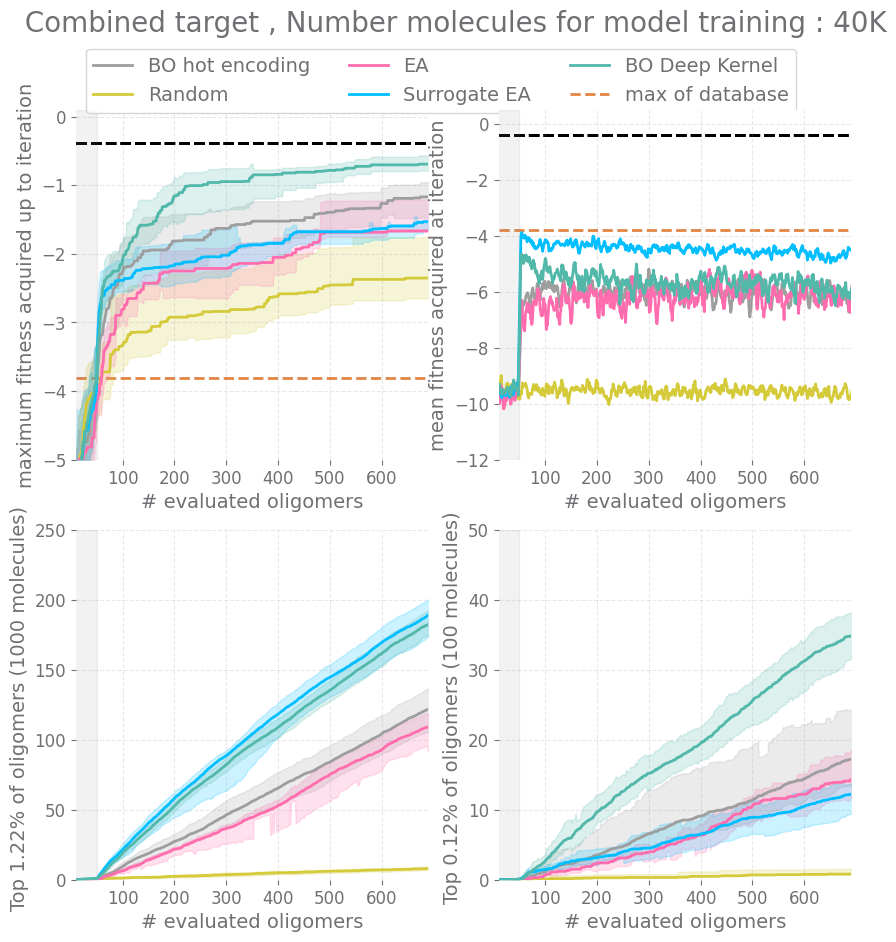

In [13]:
import glob
import pickle

def load_search_data(search_type, date,test_name,min_eval=100):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:

        with open(file, 'rb') as f:
            results = pickle.load(f)
            if len(results['fitness_acquired'])>min_eval:
                BOresults.append(results)
    print(search_type,len(BOresults))
    return BOresults
def load_search_data(search_type, date,test_name,min_eval=100):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    max_num_eval = 0
    for file in files:

        with open(file, 'rb') as f:
            results = pickle.load(f)
            if len(results['fitness_acquired'])>min_eval:
                BOresults.append(results)
                max_num_eval = max(max_num_eval,len(results['fitness_acquired']))
    print(len(BOresults),max_num_eval)
    return BOresults
def plot_benchmark_results(target_name,aim,num_molecules,ylim=[-6,0],topKmol=1000,exp_name='benchmark',nb_iteration=400):
    nb_iteration = 700
    num_oligomer_frag = 6
    #BOresults_random = load_search_data(f'random_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    #BOresults_precursor = load_search_data(f'precursor_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    #BOresults_graph_frag = load_search_data(f'graph_frag_{target_name}_{num_molecules}','20240201','benchmark',min_eval=nb_iteration)
    #BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    #BOresults_SuEA = load_search_data(f'ea_surrogate_{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
    #BOresults_Learned_frag_6 = load_search_data(f'graph_frag_{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
    BOresults_Learned_frag_6 = load_search_data(f'BO_learned_{target_name}_{num_molecules}_0.0_fragmol_6','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)
    BOresults_SuEA_frag_6 = load_search_data(f'ea_surrogate_{target_name}_{num_molecules}_0.0_fragmol_6','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)
    
    BOresults_random = load_search_data(f'random_{target_name}_0.0','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)
    BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}_0.0','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)
    BOresults_precursor = load_search_data(f'BO_precursor_{target_name}_0.0','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)

    #BOresults_graph_frag = load_search_data(f'graph_frag_{target_name}_{num_molecules}_opt_count_2','20240201','benchmark',min_eval=nb_iteration)

    fig, axs = plt.subplots(2, 2, figsize=[10, 10])#, sharey=True)
    axs = axs.flatten()
    operation = np.max
    nb_initialisation = 50
    plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='BO hot encoding',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    #plot_exploration_evolution(BOresults_graph_frag, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF'], label='Learn_BO',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Random',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    #plot_exploration_evolution(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='Surrogate EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    #plot_exploration_evolution(BOresults_graph_frag_opt, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color='C9',label='BO Deep Kernel',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_SuEA_frag_6, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='Surrogate EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_Learned_frag_6, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color='C9',label='BO Deep Kernel',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    # for all axis shade area from 0 to 20 
    for ax in axs:

        target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
        min_target_out_of_database = -np.sort(-target)[1000]
        ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
        ax.axvspan(0, nb_initialisation, alpha=0.1, color='grey')
        ax.set_ylim(ylim)
    axs[2].set_ylim(0,20)
    #axs[3].axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    #plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

    axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.2),fontsize=14,ncol=3)
    if target_name == 'target':
        target_name_plot = ' Combined target '
    else:
        target_name_plot = target_name
    fig.suptitle(f'{target_name_plot}, Number molecules for model training : 40K',fontsize=20)#, Number molecules for model training 75K
    #fig.tight_layout()
    return fig,axs
dict_targets = {'target':0,'fosc1':10,'ES1':3,'IP':5.5}#
for target_name,aim in dict_targets.items():
    fig, axs = plot_benchmark_results(target_name,aim,40000,ylim=[-12,0.5],topKmol=1000)
    axs[2].set_ylim(0,250)
    axs[3].set_ylim(0,50)
    for ax in axs:
        ax.set_xlim(10,690)
    axs[0].set_ylim(-5,0.1)
    break
    ax

25 1050
25 891
22 1050
25 1050
12 1050


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.0, 50.0)

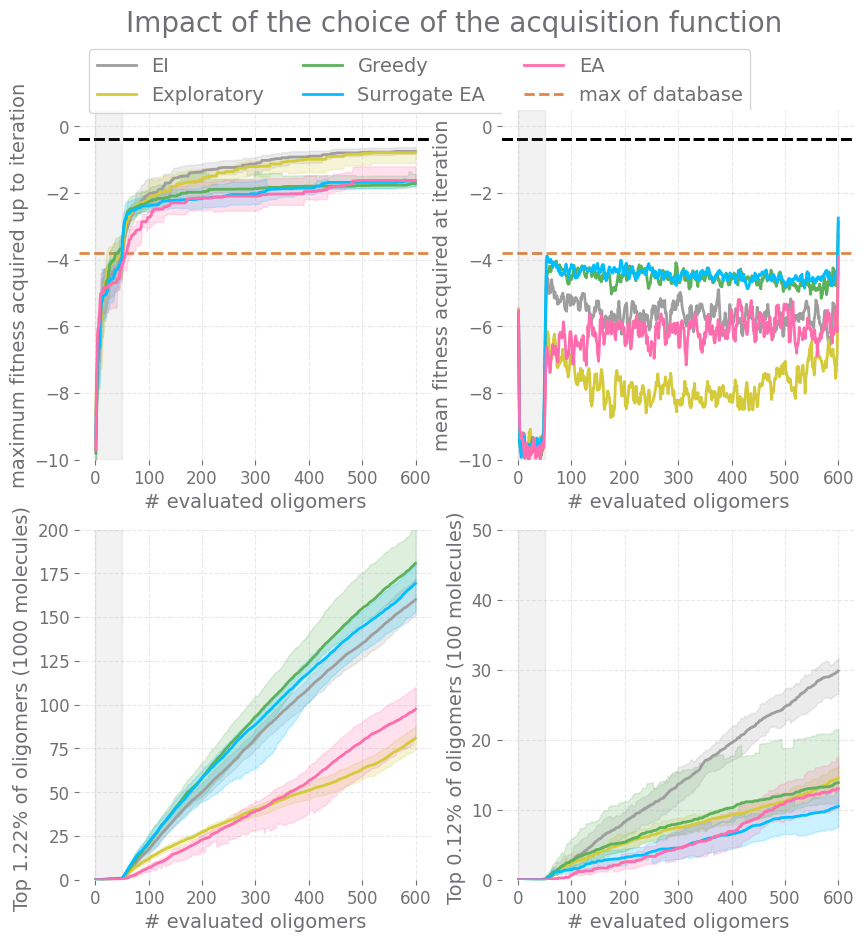

In [16]:
topKmol = 1000
ylim = [-10,0.5]
num_oligomer_frag = 6
nb_iteration = 600
BO_EI= load_search_data(f'BO_learned_{target_name}_{40000}_0.0_fragmol_6_acq_EI','*',f'{6}_frag/benchmark',min_eval=nb_iteration)
BO_max_sigma= load_search_data(f'BO_learned_{target_name}_{40000}_0.0_fragmol_6_acq_max_sigma','*',f'{6}_frag/benchmark',min_eval=nb_iteration)
BO__max_y_hat= load_search_data(f'BO_learned_{target_name}_{40000}_0.0_fragmol_6_acq_max_y_hat','*',f'{6}_frag/benchmark',min_eval=nb_iteration)
BOresults_SuEA_frag_6 = load_search_data(f'ea_surrogate_{target_name}_{40000}_0.0_fragmol_6','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)
BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}_0.0','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)

fig, axs = plt.subplots(2, 2, figsize=[10, 10])#, sharey=True)
axs = axs.flatten()
operation = np.max
nb_initialisation = 50
plot_exploration_evolution(BO_EI, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='EI',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
plot_exploration_evolution(BO_max_sigma, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Exploratory',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
plot_exploration_evolution(BO__max_y_hat, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color='C7',label='Greedy',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
plot_exploration_evolution(BOresults_SuEA_frag_6, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='Surrogate EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)

# for all axis shade area from 0 to 20 
for ax in axs:

    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, nb_initialisation, alpha=0.1, color='grey')
    ax.set_ylim(ylim)
axs[2].set_ylim(0,20)
#axs[3].axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.2),fontsize=14,ncol=3)
if target_name == 'target':
    target_name_plot = ' Combined target '
else:
    target_name_plot = target_name
fig.suptitle(f'Impact of the choice of the acquisition function',fontsize=20)#, Number molecules for model training 75K
axs[2].set_ylim(0,200)
axs[3].set_ylim(0,50)


50 550
42 550
39 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.0, 50.0)

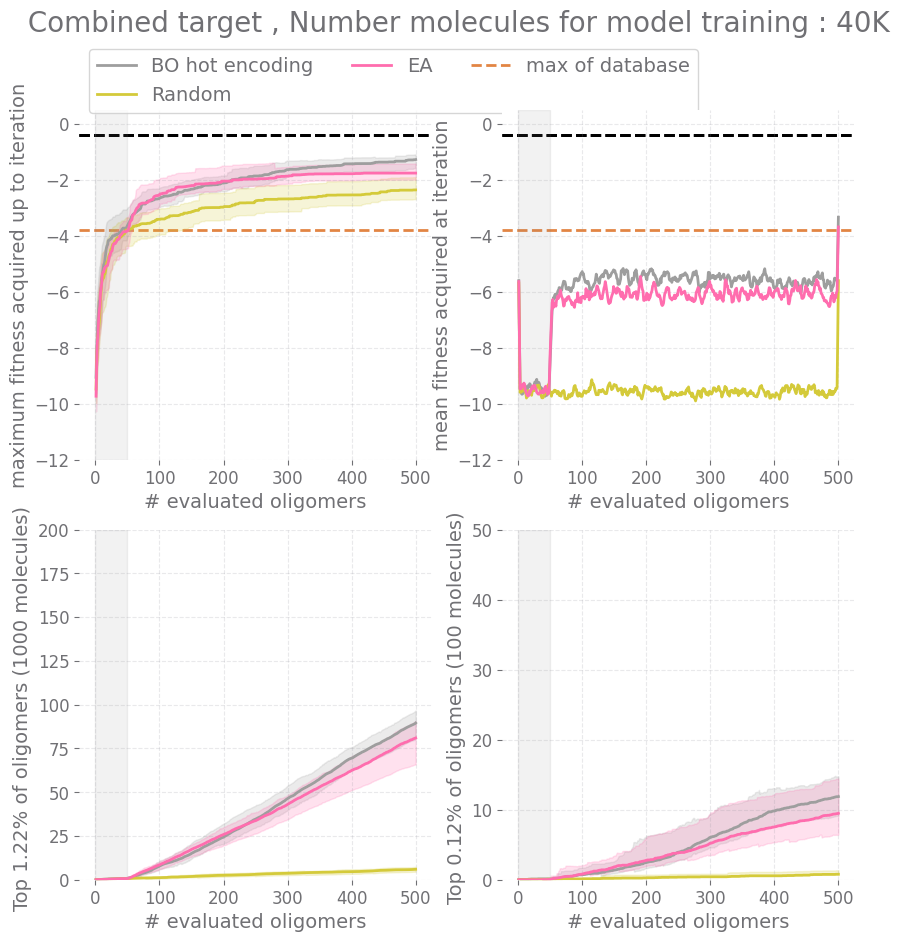

In [13]:
# plot ip and fosc1 for 
import glob
import pickle

def load_search_data(search_type, date,test_name,min_eval=100):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:

        with open(file, 'rb') as f:
            results = pickle.load(f)
            if len(results['fitness_acquired'])>min_eval:
                BOresults.append(results)
    print(search_type,len(BOresults))
    return BOresults
def load_search_data(search_type, date,test_name,min_eval=100):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    max_num_eval = 0
    for file in files:

        with open(file, 'rb') as f:
            results = pickle.load(f)
            if len(results['fitness_acquired'])>min_eval:
                BOresults.append(results)
                max_num_eval = max(max_num_eval,len(results['fitness_acquired']))
    print(len(BOresults),max_num_eval)
    return BOresults
def plot_benchmark_results(target_name,aim,num_molecules,ylim=[-6,0],topKmol=1000,exp_name='benchmark',nb_iteration=400):
    nb_iteration = 500
    num_oligomer_frag = 6
    BOresults_random = load_search_data(f'random_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    BOresults_precursor = load_search_data(f'precursor_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    #BOresults_graph_frag = load_search_data(f'graph_frag_{target_name}_{num_molecules}','20240201','benchmark',min_eval=nb_iteration)
    BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    #BOresults_SuEA = load_search_data(f'ea_surrogate_{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
    #BOresults_graph_frag = load_search_data(f'graph_frag_{target_name}_{num_molecules}_opt_count_2','20240201','benchmark',min_eval=nb_iteration)

    fig, axs = plt.subplots(2, 2, figsize=[10, 10])#, sharey=True)
    axs = axs.flatten()
    operation = np.max
    nb_initialisation = 50
    plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='BO hot encoding',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    #plot_exploration_evolution(BOresults_graph_frag, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF'], label='Learn_BO',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Random',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    #plot_exploration_evolution(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='Surrogate EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    #plot_exploration_evolution(BOresults_graph_frag_opt, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color='C9',label='BO Deep Kernel',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)

    # for all axis shade area from 0 to 20 
    for ax in axs:

        target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
        min_target_out_of_database = -np.sort(-target)[1000]
        ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
        ax.axvspan(0, nb_initialisation, alpha=0.1, color='grey')
        ax.set_ylim(ylim)
    axs[2].set_ylim(0,20)
    #axs[3].axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    #plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

    axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.2),fontsize=14,ncol=3)
    if target_name == 'target':
        target_name_plot = ' Combined target '
    else:
        target_name_plot = target_name
    fig.suptitle(f'{target_name_plot}, Number molecules for model training : 40K',fontsize=20)#, Number molecules for model training 75K
    #fig.tight_layout()
    return fig,axs
dict_targets = {'target':0,'fosc1':10,'ES1':3,'IP':5.5}#
target_name,aim = 'target',0#'IP',5.5
fig, axs = plot_benchmark_results(target_name,aim,40000,ylim=[-12,0.5],topKmol=1000)
axs[2].set_ylim(0,200)
axs[3].set_ylim(0,50)


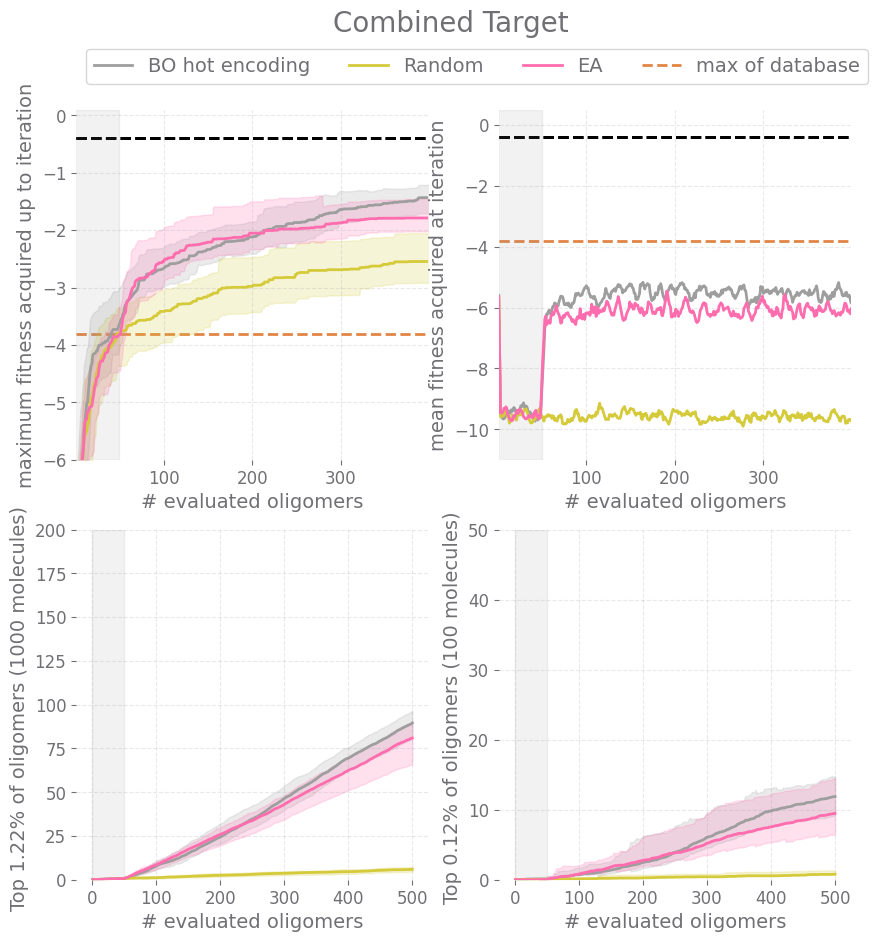

In [15]:
axs[1].set_ylim(-11,0.5)
axs[0].set_ylim(-6,0.1)
axs[0].set_xlim(1,399)
axs[1].set_xlim(1,399)
axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.2),fontsize=14,ncol=4)
fig.suptitle("Combined Target",fontsize=20)
fig.show()
fig

50 550
42 550
39 550
16 550
25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550
21 550
17 550
24 550
25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550
24 550
16 550
25 550
25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


50 550
42 550
39 550
16 550
25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550
21 550
17 550
24 550
25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550
24 550
16 550
25 550
25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


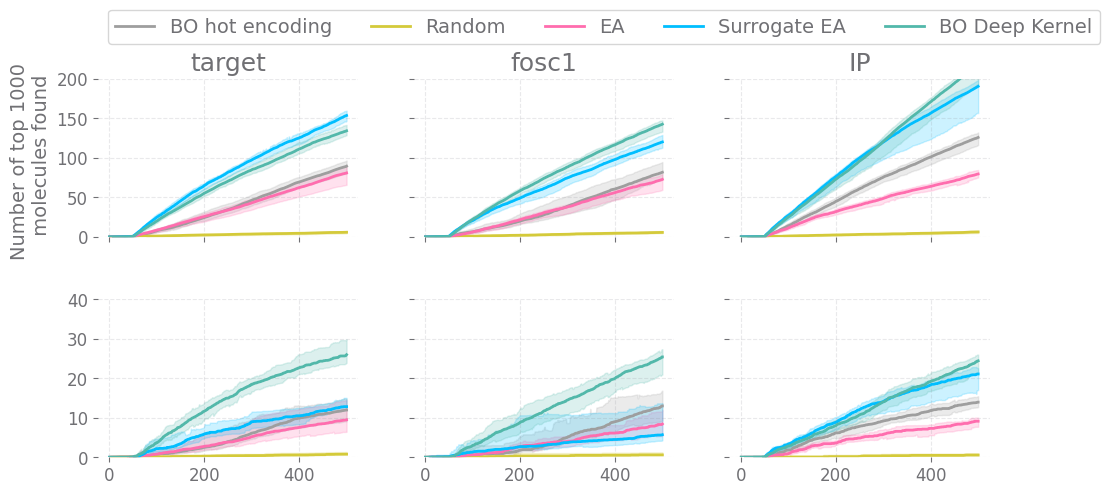

In [166]:
def plot_exploration_evolution_elem_only(BOresults, df_total_org, nb_initialisation,nb_iteration=100,axs=None,color=search_to_color['BO'],label='BO',operation= np.max,target_name='target',aim=0.0,topKmol = 1000):
    

    df_total=df_total_org.copy()
    df_total[target_name] = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2))
    min_target_out_of_database = -np.sort(-df_total[target_name].values)[topKmol]
    y_elm, y_elm_sig_bot, y_elm_sig_top = plot_element_above_min(BOresults,min_target_out_of_database,nb_iterations=nb_iteration, topKmol = topKmol,axs=axs,color=color,label=label,df_total=df_total,nb_initialisation=nb_initialisation)

def plot_compare_target(num_molecules,topKmol=1000):
    nb_iteration = 500
    nb_initialisation = 0
    operation = np.max


    fig, axis = plt.subplots(2, 3, figsize=[10, 5])#, sharey=True)

    axis = axis.flatten()
    dict_targets = {'target':0,'fosc1':10,'IP':5.5}#
    counter = 0
    for target_name,aim in dict_targets.items():
        axs = axis[counter]
        BOresults_random = load_search_data(f'random_{target_name}','20240201','benchmark',min_eval=nb_iteration)
        BOresults_precursor = load_search_data(f'precursor_{target_name}','20240201','benchmark',min_eval=nb_iteration)
        BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240201','benchmark',min_eval=nb_iteration)
        BOresults_SuEA = load_search_data(f'ea_surrogate_{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
        BOresults_graph_frag_opt = load_search_data(f'graph_frag_{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
        plot_exploration_evolution_elem_only(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='BO hot encoding',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        plot_exploration_evolution_elem_only(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Random',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        plot_exploration_evolution_elem_only(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        plot_exploration_evolution_elem_only(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='Surrogate EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        plot_exploration_evolution_elem_only(BOresults_graph_frag_opt, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color='C9',label='BO Deep Kernel',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        axs.set_ylim(0,200)
        axs.set_title(target_name)
        axs.set_xticklabels([])
        if counter != 0:
            axs.set_yticklabels([])
        counter +=1
    for target_name,aim in dict_targets.items():
        axs = axis[counter]
        BOresults_random = load_search_data(f'random_{target_name}','20240201','benchmark',min_eval=nb_iteration)
        BOresults_precursor = load_search_data(f'precursor_{target_name}','20240201','benchmark',min_eval=nb_iteration)
        BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240201','benchmark',min_eval=nb_iteration)
        BOresults_SuEA = load_search_data(f'ea_surrogate_{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
        BOresults_graph_frag_opt = load_search_data(f'graph_frag_{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
        plot_exploration_evolution_elem_only(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='BO hot encoding',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        plot_exploration_evolution_elem_only(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Random',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        plot_exploration_evolution_elem_only(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        plot_exploration_evolution_elem_only(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='Surrogate EA',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        plot_exploration_evolution_elem_only(BOresults_graph_frag_opt, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color='C9',label='BO Deep Kernel',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        axs.set_ylim(0,40)
        if counter != 3:
            axs.set_yticklabels([])
        counter +=1
    fig.tight_layout()
    axis[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.5),fontsize=14,ncol=5)
    # delete axis x lable
    for ax in axis:

        ax.set_xlabel('')
        ax.set_ylabel('')

    axis[0].set_ylabel('Number of top 1000 \n molecules found',fontsize=14)
    
    #
    return fig,axis
fig, axs = plot_compare_target(75000,topKmol=1000)






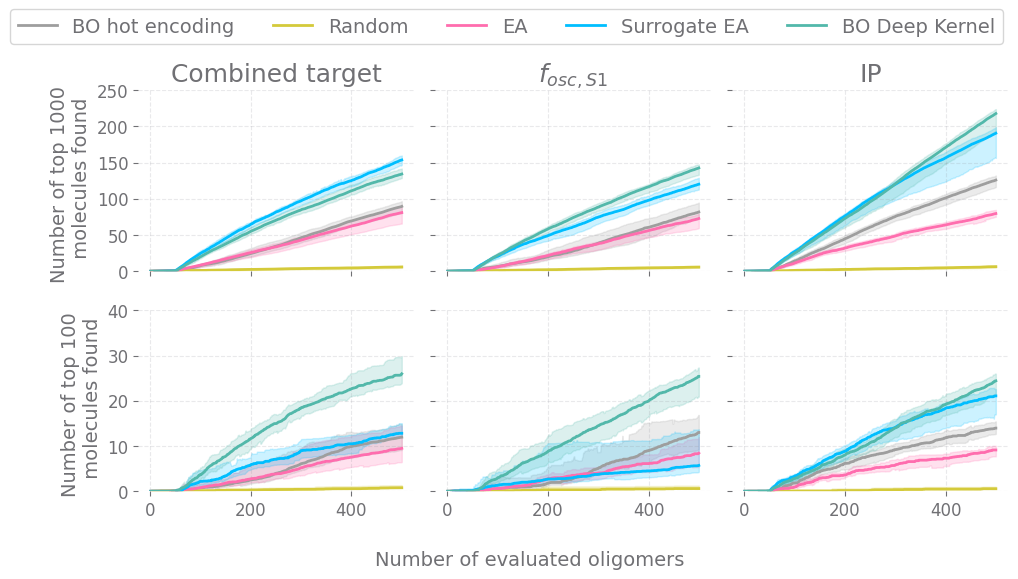

In [167]:
axs[0].set_ylabel('Number of top 1000 \n molecules found',fontsize=14)

axs[0].legend([])
for i in range(3):
    axs[i].set_ylim(0,250)
axs[3].set_ylabel('Number of top 100 \n molecules found',fontsize=14)
axs[0].set_title('Combined target')
axs[1].set_title('$f_{osc,S1}$')
#axs[2].set_title('$E_{S1}$')
# add x label centered 
fig.tight_layout()
axs[0].legend(loc='upper left', bbox_to_anchor=(-0.5, 1.5),fontsize=14,ncol=5)
fig.text(0.5, -0.05, 'Number of evaluated oligomers', ha='center',fontsize=14)

fig

25 550
24 550
16 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550
25 550
25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


21 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


23 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


21 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


23 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


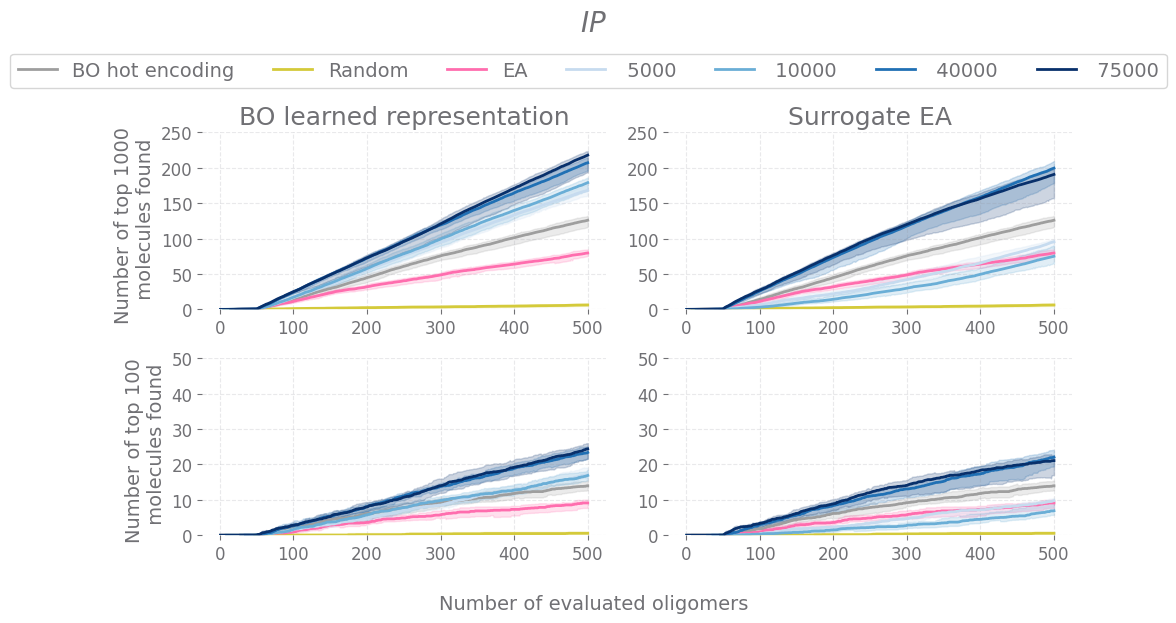

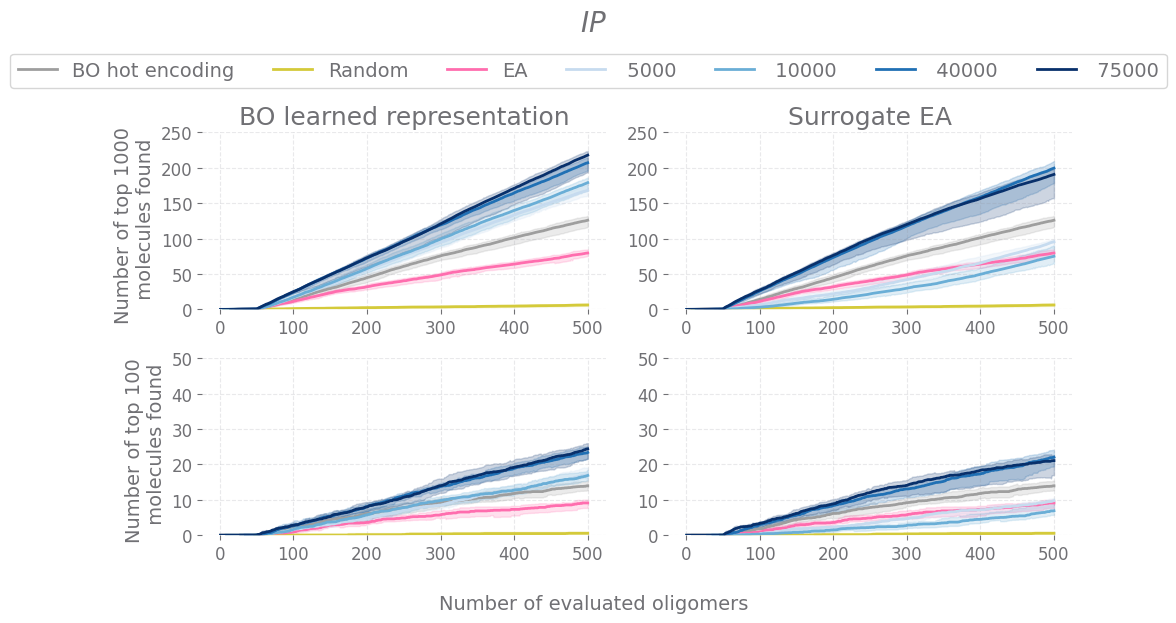

In [162]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_benchmark_results_num_mol(target_name,aim,topKmol=1000):
    nb_iteration = 500
    fig, axis = plt.subplots(2, 2, figsize=[10, 5])#, sharey=True)
    axis = axis.flatten()
    operation = np.max
    nb_initialisation = 0
    BOresults_random = load_search_data(f'random_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    BOresults_precursor = load_search_data(f'precursor_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240201','benchmark',min_eval=nb_iteration)


    # Create a gradient of colors
    counter = 0
    labels = ['BO deep kernel', 'surrogate EA']
    for search_algo in ["graph_frag_","ea_surrogate_"]:
        axs = axis[counter]
        plot_exploration_evolution_elem_only(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='BO hot encoding',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        plot_exploration_evolution_elem_only(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Random',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        plot_exploration_evolution_elem_only(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        num_colors = 5  # Change this to the number of colors you want
        colors = [cm.Blues(x) for x in np.linspace(0, 1, num_colors)]
        for i, num_molecules  in enumerate([5000,10000,40000,75000]):
            BO_results = load_search_data(f'{search_algo}{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
            if len(BO_results)>0:
                plot_exploration_evolution_elem_only(BO_results, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=colors[i+1],label=f' {num_molecules}',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
        axs.set_ylim(0,40)
        axs.set_title(labels[counter])
        counter +=1
        # for all axis shade area from 0 to 20 
    for search_algo in ["graph_frag_","ea_surrogate_"]:
        axs = axis[counter]
        plot_exploration_evolution_elem_only(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='BO hot encoding',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        plot_exploration_evolution_elem_only(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Random',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        plot_exploration_evolution_elem_only(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        num_colors = 5  # Change this to the number of colors you want
        colors = [cm.Blues(x) for x in np.linspace(0, 1, num_colors)]
        for i, num_molecules  in enumerate([5000,10000,40000,75000]):
            BO_results = load_search_data(f'{search_algo}{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
            if len(BO_results)>0:
                plot_exploration_evolution_elem_only(BO_results, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=colors[i+1],label=f' {num_molecules}',operation=operation,target_name=target_name,aim=aim,topKmol=100)
        axs.set_ylim(0,250)

        counter +=1
    fig.tight_layout()
    axis[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.3),fontsize=14,ncol=4)

    return fig,axis
fig, axs = plot_benchmark_results_num_mol('IP',5.5,topKmol=1000)
axs[0].set_ylabel('Number of top 1000 \n molecules found',fontsize=14)

axs[0].legend([])
axs[0].set_title('BO learned representation')
axs[1].set_title('Surrogate EA')

axs[2].set_ylabel('Number of top 100 \n molecules found',fontsize=14)
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[0].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')
axs[3].set_ylabel('')
axs[0].set_ylim(0,250)
axs[1].set_ylim(0,250)
axs[2].set_ylim(0,50)
axs[3].set_ylim(0,50)
# add x label centered 
fig.tight_layout()
axs[0].legend(loc='upper left', bbox_to_anchor=(-0.5, 1.5),fontsize=14,ncol=7)
fig.text(0.5, -0.05, 'Number of evaluated oligomers', ha='center',fontsize=14)

fig.suptitle('$IP$',fontsize=20, y=1.15)
fig

25 550
21 550
17 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550
21 550
24 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


21 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


24 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


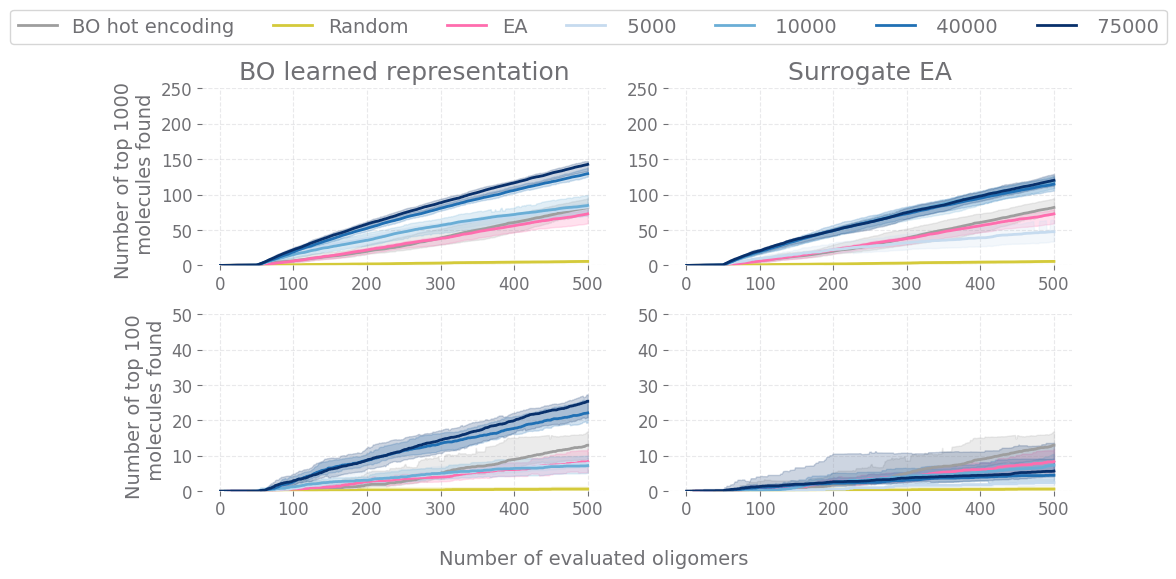

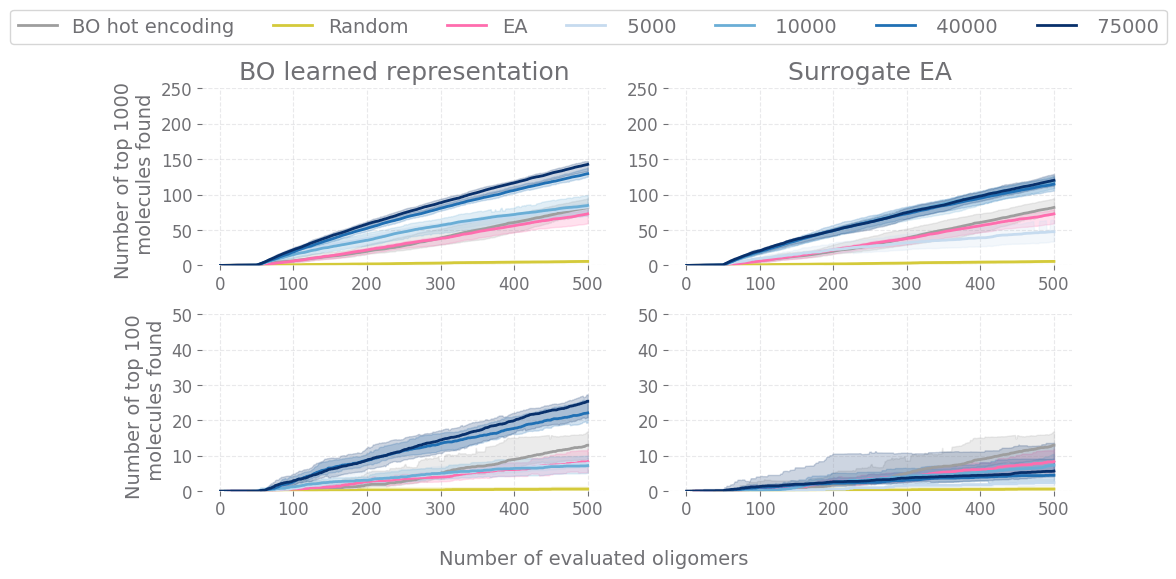

In [157]:

fig, axs = plot_benchmark_results_num_mol('fosc1',10,topKmol=1000)
axs[0].set_ylabel('Number of top 1000 \n molecules found',fontsize=14)

axs[0].legend([])
axs[0].set_title('BO learned representation')
axs[1].set_title('Surrogate EA')

axs[2].set_ylabel('Number of top 100 \n molecules found',fontsize=14)
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[0].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')
axs[3].set_ylabel('')
axs[0].set_ylim(0,250)
axs[1].set_ylim(0,250)
axs[2].set_ylim(0,50)
axs[3].set_ylim(0,50)
# add x label centered 
fig.tight_layout()
axs[0].legend(loc='upper left', bbox_to_anchor=(-0.5, 1.5),fontsize=14,ncol=7)
fig.text(0.5, -0.05, 'Number of evaluated oligomers', ha='center',fontsize=14)

fig.suptitle('$f_{osc,S1}$',fontsize=20, y=1.15)
fig

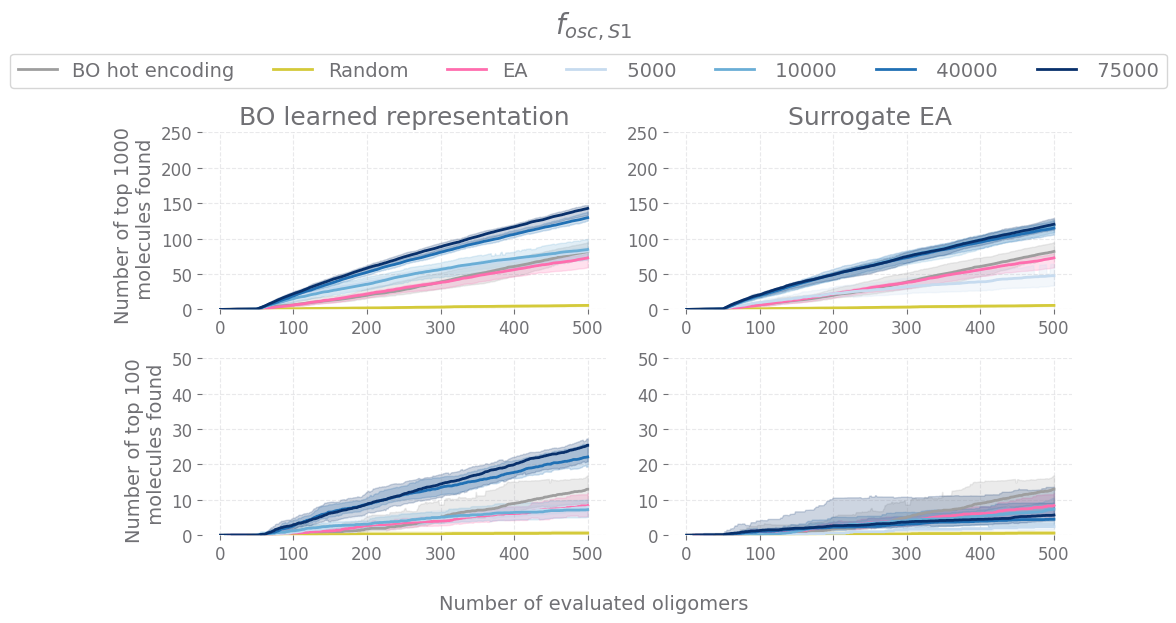

## 3 fragement


In [3]:
from stk_search import Database_utils
import importlib
importlib.reload(Database_utils)
df_precursors_path = "data/output/Prescursor_data/calculation_data_precursor_190923_clean.pkl"  #'Data/output/Prescursor_data/calculation_data_precursor_310823_clean.pkl'

df_total,df_precursor = Database_utils.load_data_database(df_precursors_path,num_fragm =3) 
df_path = "data/output/Full_dataset/3_frag_05022024.csv"
df_total.to_csv(df_path)
df_total.shape

(28881, 60)

48 220
25 220
43 220
49 220


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


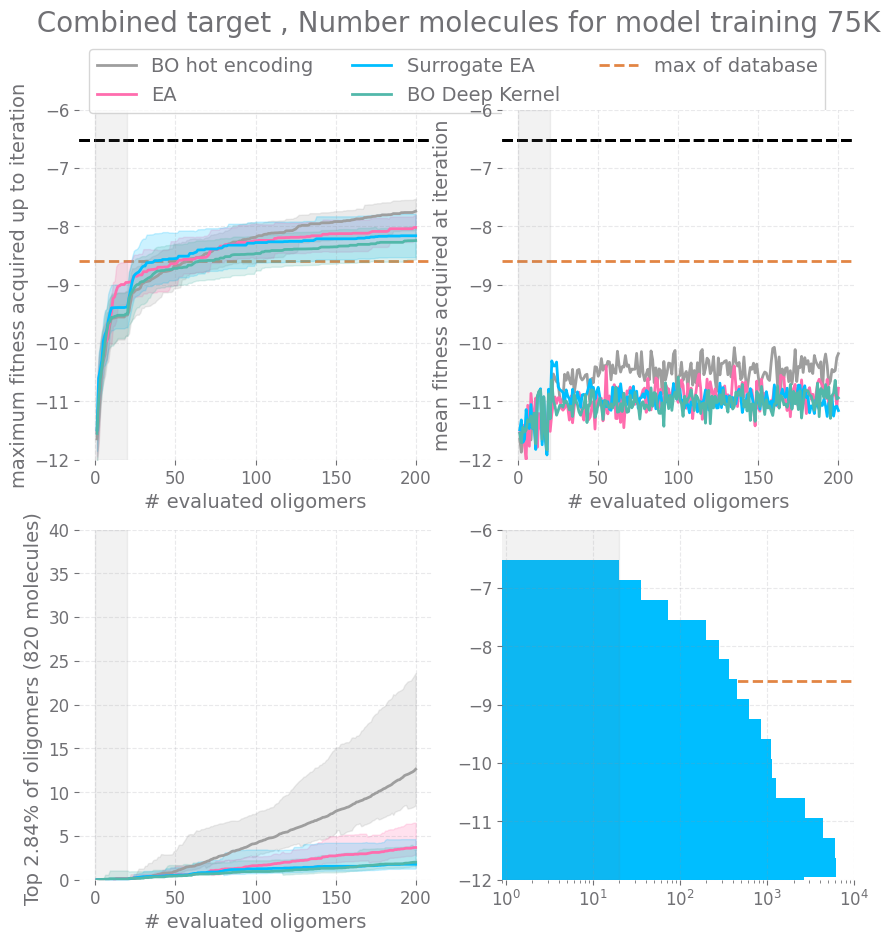

In [4]:
import glob
import pickle

def load_search_data(search_type, date,test_name,min_eval=100):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    max_num_eval = 0
    for file in files:

        with open(file, 'rb') as f:
            results = pickle.load(f)
            if len(results['fitness_acquired'])>min_eval:
                BOresults.append(results)
                max_num_eval = max(max_num_eval,len(results['fitness_acquired']))
    print(len(BOresults),max_num_eval)
    return BOresults
def plot_benchmark_results(target_name,aim,num_molecules,ylim=[-6,0],topKmol=1000,exp_name='benchmark',nb_iteration=400):
    nb_iteration = 200

    #BOresults_random = load_search_data(f'random_{target_name}','*',exp_name,min_eval=nb_iteration)
    BOresults_precursor = load_search_data(f'BO_precursor_{target_name}','*',exp_name,min_eval=nb_iteration)
    BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','*',exp_name,min_eval=nb_iteration)
    BOresults_SuEA = load_search_data(f'ea_surrogate_{target_name}_{num_molecules}_opt','*',exp_name,min_eval=nb_iteration)
    BOresults_graph_frag_opt = load_search_data(f'BO_learned_{target_name}_{num_molecules}_opt','*',exp_name,min_eval=nb_iteration)

    fig, axs = plt.subplots(2, 2, figsize=[10, 10])#, sharey=True)
    axs = axs.flatten()
    operation = np.max
    nb_initialisation = 0
    plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='BO hot encoding',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    #plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Random',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='Surrogate EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_graph_frag_opt, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color='C9',label='BO Deep Kernel',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)

    # for all axis shade area from 0 to 20 
    for ax in axs:

        target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
        min_target_out_of_database = -np.sort(-target)[1000]
        ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
        ax.axvspan(0, 20, alpha=0.1, color='grey')
        ax.set_ylim(ylim)
    axs[2].set_ylim(0,20)
    #plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

    axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.2),fontsize=14,ncol=3)
    if target_name == 'target':
        target_name_plot = ' Combined target '
    else:
        target_name_plot = target_name
    fig.suptitle(f'{target_name_plot}, Number molecules for model training 75K',fontsize=20)#, Number molecules for model training 75K
    #fig.tight_layout()
    return fig,axs
dict_targets = {'target':0,'fosc1':10,'ES1':3,'IP':5.5}#
for target_name,aim in dict_targets.items():
    fig, axs = plot_benchmark_results(target_name,aim,75000,ylim=[-12,-6],topKmol=820,exp_name='3_frag')
    axs[2].set_ylim(0,40)
    break

25 1050
25 758
25 1050
25 728
25 1050
25 1050


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


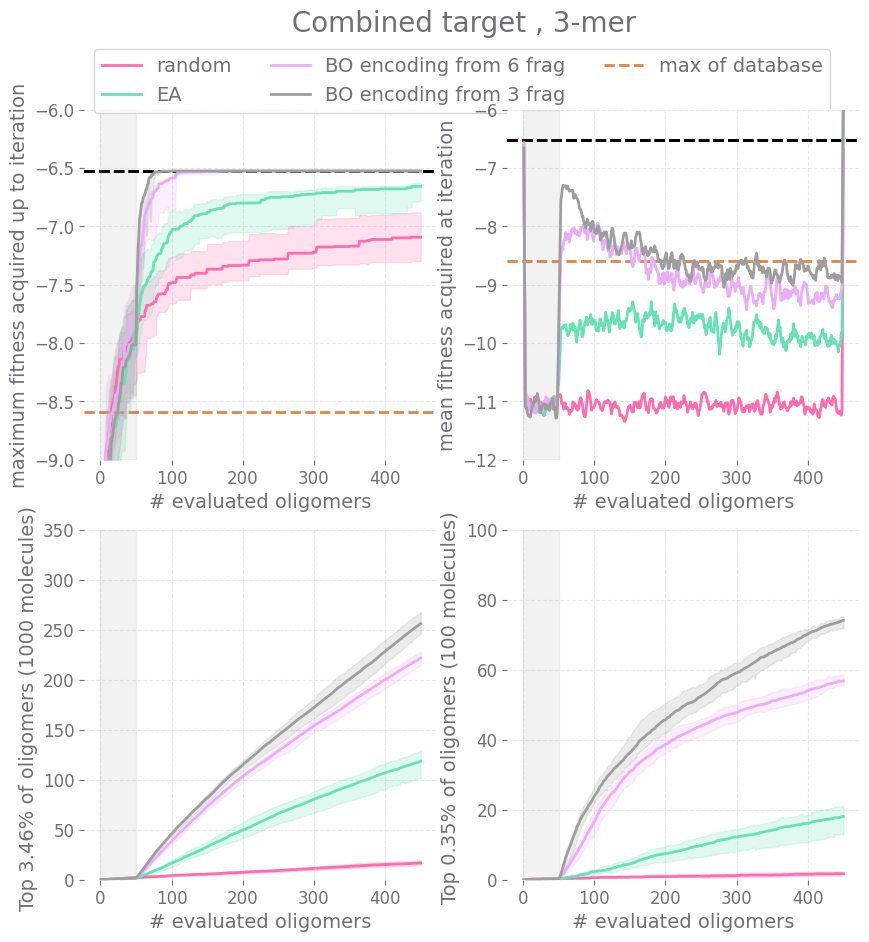

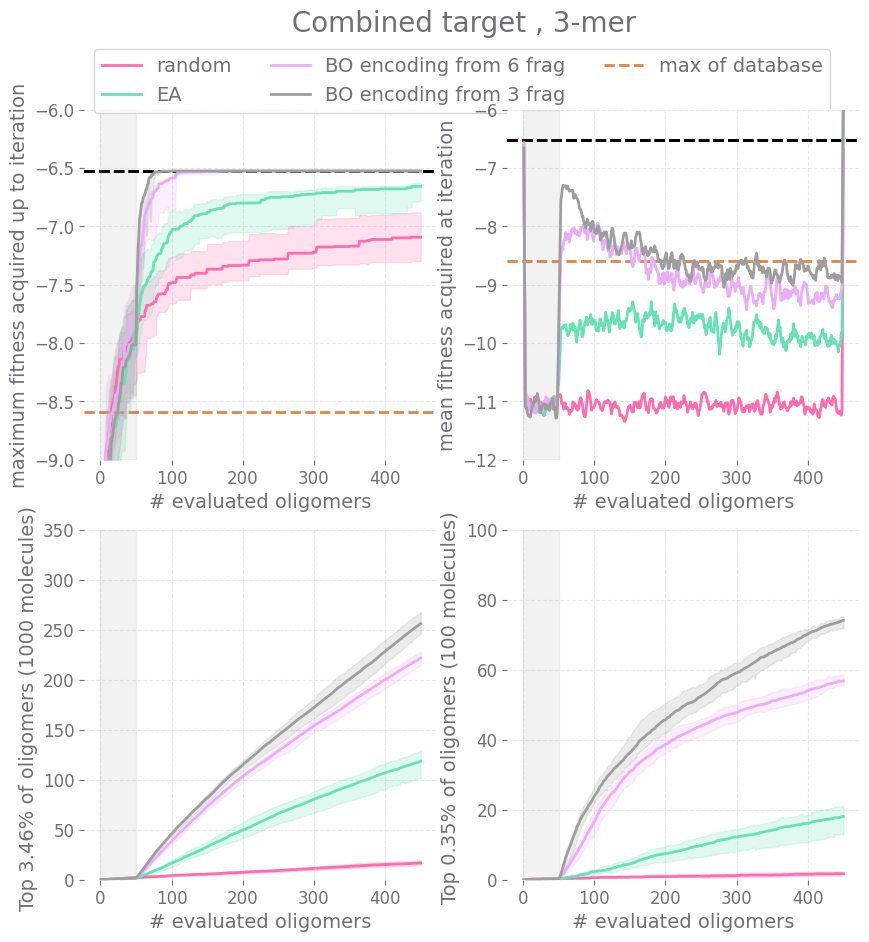

In [27]:
df_path = "data/output/Full_dataset/3_frag_05022024.csv"
df_total = pd.read_csv(df_path)
nb_iteration = 450
ylim = [-12,-6]
BOresults_SuEA_frag_6 = load_search_data(f'ea_surrogate_{target_name}_{40000}_0.0_fragmol_6','*','3_frag/benchmark',min_eval=nb_iteration)
BOresults_Learned_frag_6 = load_search_data(f'BO_learned_{target_name}_{40000}_0.0_fragmol_6','*','3_frag/benchmark',min_eval=nb_iteration)

BOresults_SuEA_frag_3 = load_search_data(f'ea_surrogate_{target_name}_{27000}_0.0_fragmol_3','*','3_frag/benchmark',min_eval=nb_iteration)
BOresults_Learned_frag_3 = load_search_data(f'BO_learned_{target_name}_{27000}_0.0_fragmol_3','*','3_frag/benchmark',min_eval=nb_iteration)

BOresults_random = load_search_data(f'random_{target_name}_0.0','*','3_frag/benchmark',min_eval=nb_iteration)
BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}_0.0','*','3_frag/benchmark',min_eval=nb_iteration)

fig, axs = plt.subplots(2, 2, figsize=[10, 10])#, sharey=True)
axs = axs.flatten()
operation = np.max
nb_initialisation = 0
#plot_exploration_evolution(BOresults_SuEA_frag_6, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C0',label='SuEA encoding from 6 frag',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
#plot_exploration_evolution(BOresults_SuEA_frag_3, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C1',label='SuEA encoding from 3 frag',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
plot_exploration_evolution(BOresults_random, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C2',label='random',operation=operation,target_name=target_name,aim=aim,topKmol= 1000)
plot_exploration_evolution(BOresults_EA, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C3',label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
plot_exploration_evolution(BOresults_Learned_frag_6, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C4',label='BO encoding from 6 frag',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
plot_exploration_evolution(BOresults_Learned_frag_3, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C5',label='BO encoding from 3 frag',operation=operation,target_name=target_name,aim=aim,topKmol=1000)

for ax in axs:

    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, 50, alpha=0.1, color='grey')
    ax.set_ylim(ylim)
axs[2].set_ylim(0,100)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.2),fontsize=14,ncol=3)
if target_name == 'target':
    target_name_plot = ' Combined target '
else:
    target_name_plot = target_name
fig.suptitle(f'{target_name_plot}, 3-mer',fontsize=20)#, Number molecules for model training 75K
axs[3].set_ylim(0,100)
axs[2].set_ylim(0,350)
axs[0].set_ylim(-9,-6)
axs[1].set_ylim(-12,-6)
fig

25 1050
23 1008
25 1050
21 1050
25 1050
8 1050


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


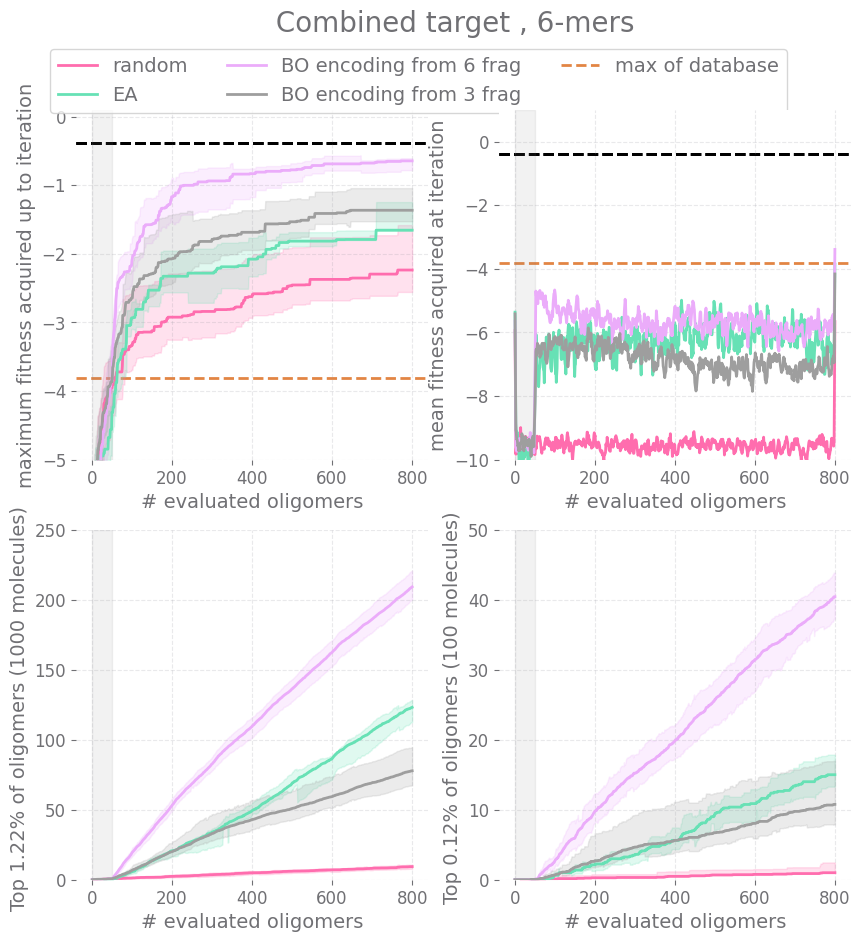

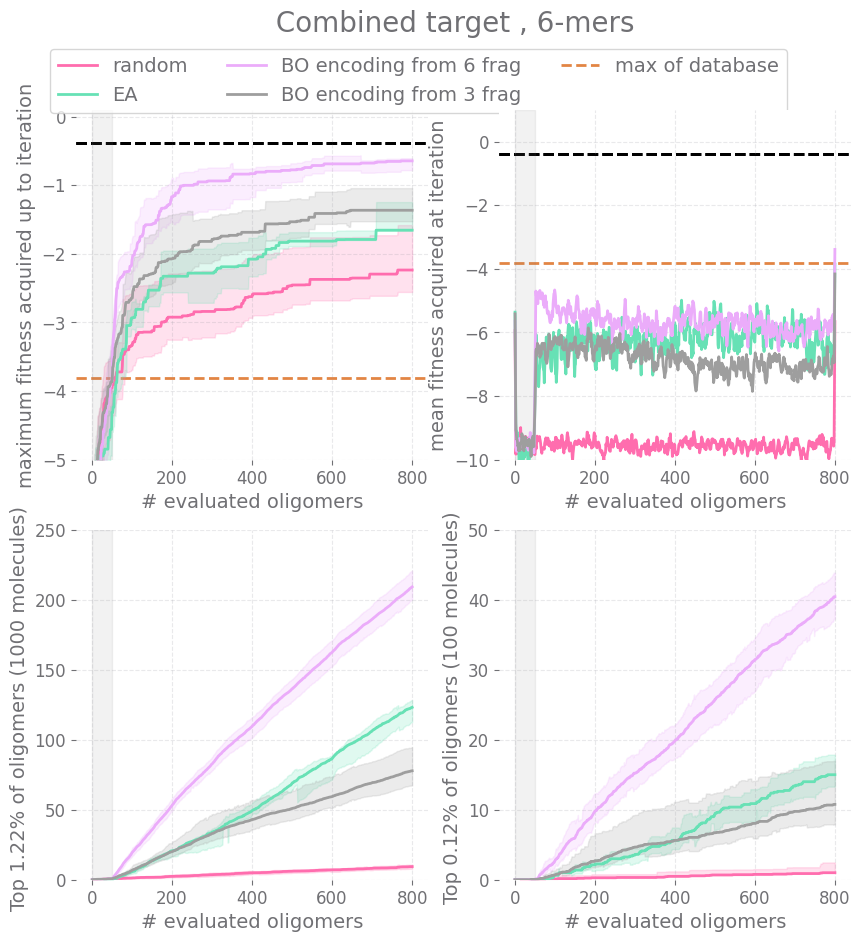

In [29]:
df_path = "data/output/Full_dataset/df_total_2024-01-05.csv"
df_total = pd.read_csv(df_path)
nb_iteration = 800
num_oligomer_frag = 6
ylim = [-7,0]
BOresults_SuEA_frag_6 = load_search_data(f'ea_surrogate_{target_name}_{40000}_0.0_fragmol_6','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)
BOresults_Learned_frag_6 = load_search_data(f'BO_learned_{target_name}_{40000}_0.0_fragmol_6','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)

BOresults_SuEA_frag_3 = load_search_data(f'ea_surrogate_{target_name}_{27000}_0.0_fragmol_3','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)
BOresults_Learned_frag_3 = load_search_data(f'BO_learned_{target_name}_{27000}_0.0_fragmol_3','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)

BOresults_random = load_search_data(f'random_{target_name}_0.0','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)
BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}_0.0','*',f'{num_oligomer_frag}_frag/benchmark',min_eval=nb_iteration)

fig, axs = plt.subplots(2, 2, figsize=[10, 10])#, sharey=True)
axs = axs.flatten()
operation = np.max
nb_initialisation = 0
#plot_exploration_evolution(BOresults_SuEA_frag_6, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C0',label='SuEA encoding from 6 frag',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
#plot_exploration_evolution(BOresults_SuEA_frag_3, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C1',label='SuEA encoding from 3 frag',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
plot_exploration_evolution(BOresults_random, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C2',label='random',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
plot_exploration_evolution(BOresults_EA, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C3',label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
plot_exploration_evolution(BOresults_Learned_frag_6, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C4',label='BO encoding from 6 frag',operation=operation,target_name=target_name,aim=aim,topKmol=1000)
plot_exploration_evolution(BOresults_Learned_frag_3, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color='C5',label='BO encoding from 3 frag',operation=operation,target_name=target_name,aim=aim,topKmol=1000)

for ax in axs:

    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, 50, alpha=0.1, color='grey')
    ax.set_ylim(ylim)
axs[2].set_ylim(0,200)
axs[3].set_ylim(0,30)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

axs[0].legend(loc='upper left', bbox_to_anchor=(-0.1, 1.2),fontsize=14,ncol=3)
if target_name == 'target':
    target_name_plot = ' Combined target '
else:
    target_name_plot = target_name
fig.suptitle(f'{target_name_plot}, 6-mers',fontsize=20)#, Number molecules for model training 75K
axs[3].set_ylim(0,50)
axs[2].set_ylim(0,250)
axs[0].set_ylim(-5,0.1)
axs[1].set_ylim(-10,1)
fig

50 550
42 550
39 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550
25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


25 550


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, ' Combined target , BO Deep Kernel')

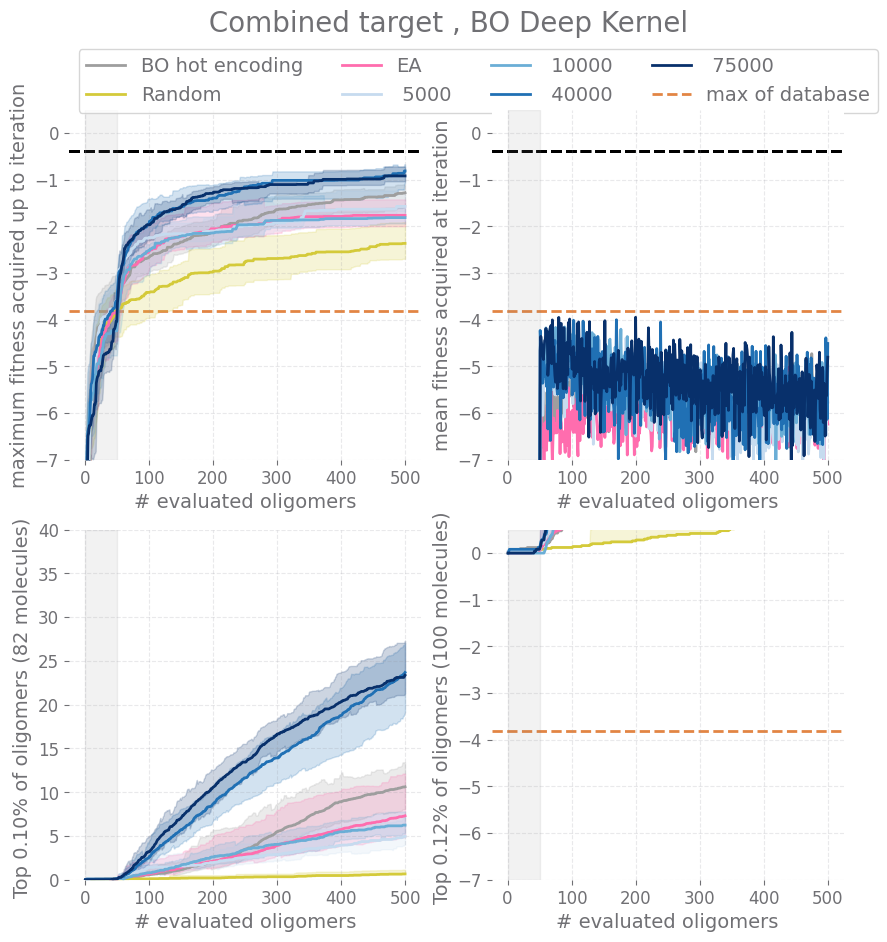

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_benchmark_results_num_mol(target_name,aim,ylim=[-6,0],topKmol=1000,search_algo= "graph_frag_"):
    nb_iteration = 500
    fig, axs = plt.subplots(2, 2, figsize=[10, 10])#, sharey=True)
    axs = axs.flatten()
    operation = np.max
    nb_initialisation = 0
    BOresults_random = load_search_data(f'random_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    BOresults_precursor = load_search_data(f'precursor_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240201','benchmark',min_eval=nb_iteration)
    plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='BO hot encoding',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='Random',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)

    # Create a gradient of colors
    num_colors = 5  # Change this to the number of colors you want
    colors = [cm.Blues(x) for x in np.linspace(0, 1, num_colors)]
    for i, num_molecules  in enumerate([5000,10000,40000,75000]):
        BO_results = load_search_data(f'{search_algo}{target_name}_{num_molecules}_opt','20240202','benchmark',min_eval=nb_iteration)
        plot_exploration_evolution(BO_results, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=colors[i+1],label=f' {num_molecules}',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    # for all axis shade area from 0 to 20 
    for ax in axs:

        target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
        min_target_out_of_database = -np.sort(-target)[1000]
        ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
        ax.axvspan(0, 50, alpha=0.1, color='grey')
        ax.set_ylim(ylim)
    axs[2].set_ylim(0,40)

    axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.2),fontsize=14,ncol=4)
    if target_name == 'target':
        target_name_plot = ' Combined target '
    else:
        target_name_plot = target_name
    fig.suptitle(f'{target_name_plot}, Number molecules for model training 75K',fontsize=20)#, Number molecules for model training 75K
    #fig.tight_layout()
    return fig,axs
fig, axs = plot_benchmark_results_num_mol('target',0,ylim=[-7,0.5],topKmol=82,search_algo= "graph_frag_")
fig.suptitle(f' Combined target , BO Deep Kernel',fontsize=20)#, Number molecules for model training 75K


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid valu

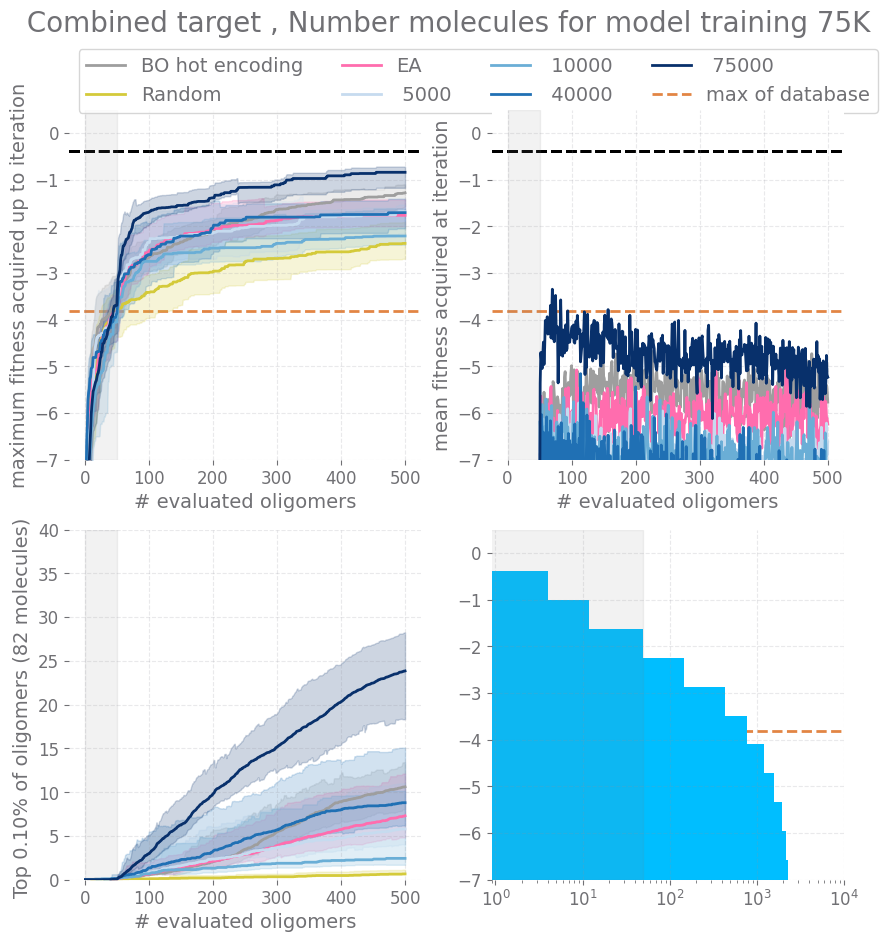

In [80]:
fig, axs = plot_benchmark_results_num_mol('target',0,ylim=[-7,0.5],topKmol=82,search_algo= "ea_surrogate_")

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


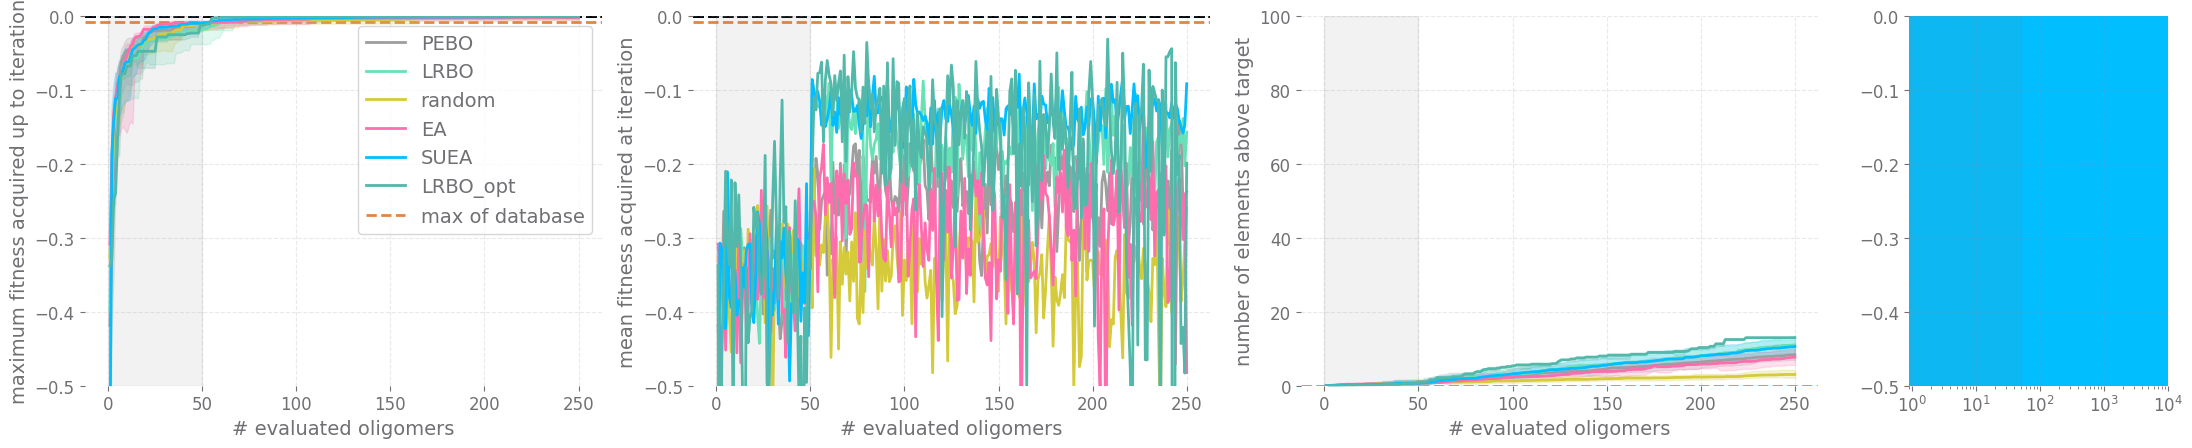

In [10]:
import glob
import pickle
target_name = 'ES1'
aim = 3.0
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
BOresults_random = load_search_data(f'random_{target_name}','20240106','benchmark')
BOresults_precursor = load_search_data(f'precursor_{target_name}','20240106','benchmark')
BOresults_graph_frag = load_search_data(f'graph_frag_{target_name}_75000','20240106','benchmark')
BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240106','benchmark')
BOresults_SuEA = load_search_data(f'ea_surrogate_{target_name}_75000','20240106','benchmark')
BOresults_graph_frag_opt = load_search_data(f'graph_frag_{target_name}_5000_opt','20240111','benchmark')

fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [4, 4, 4 ,2]}, figsize=[3.2 * 8.4, 4.8])#, sharey=True)
nb_iteration = 250
operation = np.max
nb_initialisation = 0
plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='PEBO',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_graph_frag, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF'], label='LRBO',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='SUEA',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_graph_frag_opt, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color='C9',label='LRBO_opt',operation=operation,target_name=target_name,aim=aim)

# for all axis shade area from 0 to 20 
for ax in axs:

    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, 50, alpha=0.1, color='grey')
    ax.set_ylim(-0.5,0)
axs[2].set_ylim(0,100)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

axs[0].legend()


In [ ]:
import glob
import pickle
target_name = 'fosc1'
aim = 10.0
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
BOresults_random = load_search_data(f'random_{target_name}','20240106','benchmark')
BOresults_precursor = load_search_data(f'precursor_{target_name}','20240106','benchmark')
BOresults_graph_frag = load_search_data(f'graph_frag_{target_name}_75000','20240106','benchmark')
BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240106','benchmark')
BOresults_SuEA = load_search_data(f'ea_surrogate_{target_name}_75000','20240106','benchmark')
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [4, 4, 4 ,2]}, figsize=[3.2 * 8.4, 4.8])#, sharey=True)
nb_iteration = 250
operation = np.max
nb_initialisation = 0
plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='PEBO',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_graph_frag, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF'], label='LRBO',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='SUEA',operation=operation,target_name=target_name,aim=aim)
# for all axis shade area from 0 to 20 
for ax in axs:

    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, 50, alpha=0.1, color='grey')
    #ax.set_ylim(-1,0)
axs[2].set_ylim(0,100)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

axs[0].legend()


In [ ]:
import glob
import pickle
target_name = 'fosc1'
aim = 10.0
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
BOresults_random = load_search_data(f'random_{target_name}','20240106','benchmark')
BOresults_precursor = load_search_data(f'precursor_{target_name}','20240106','benchmark')
BOresults_graph_frag = load_search_data(f'graph_frag_{target_name}_5000','20240106','benchmark')
BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240106','benchmark')
BOresults_SuEA = load_search_data(f'ea_surrogate_{target_name}_5000','20240106','benchmark')
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [4, 4, 4 ,2]}, figsize=[3.2 * 8.4, 4.8])#, sharey=True)
nb_iteration = 250
operation = np.max
nb_initialisation = 0
plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='PEBO',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_graph_frag, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF'], label='LRBO',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='SUEA',operation=operation,target_name=target_name,aim=aim)
# for all axis shade area from 0 to 20 
for ax in axs:
    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, 50, alpha=0.1, color='grey')
    #ax.set_ylim(-1,0)
axs[2].set_ylim(0,100)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

axs[0].legend()


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.0, 1.0)

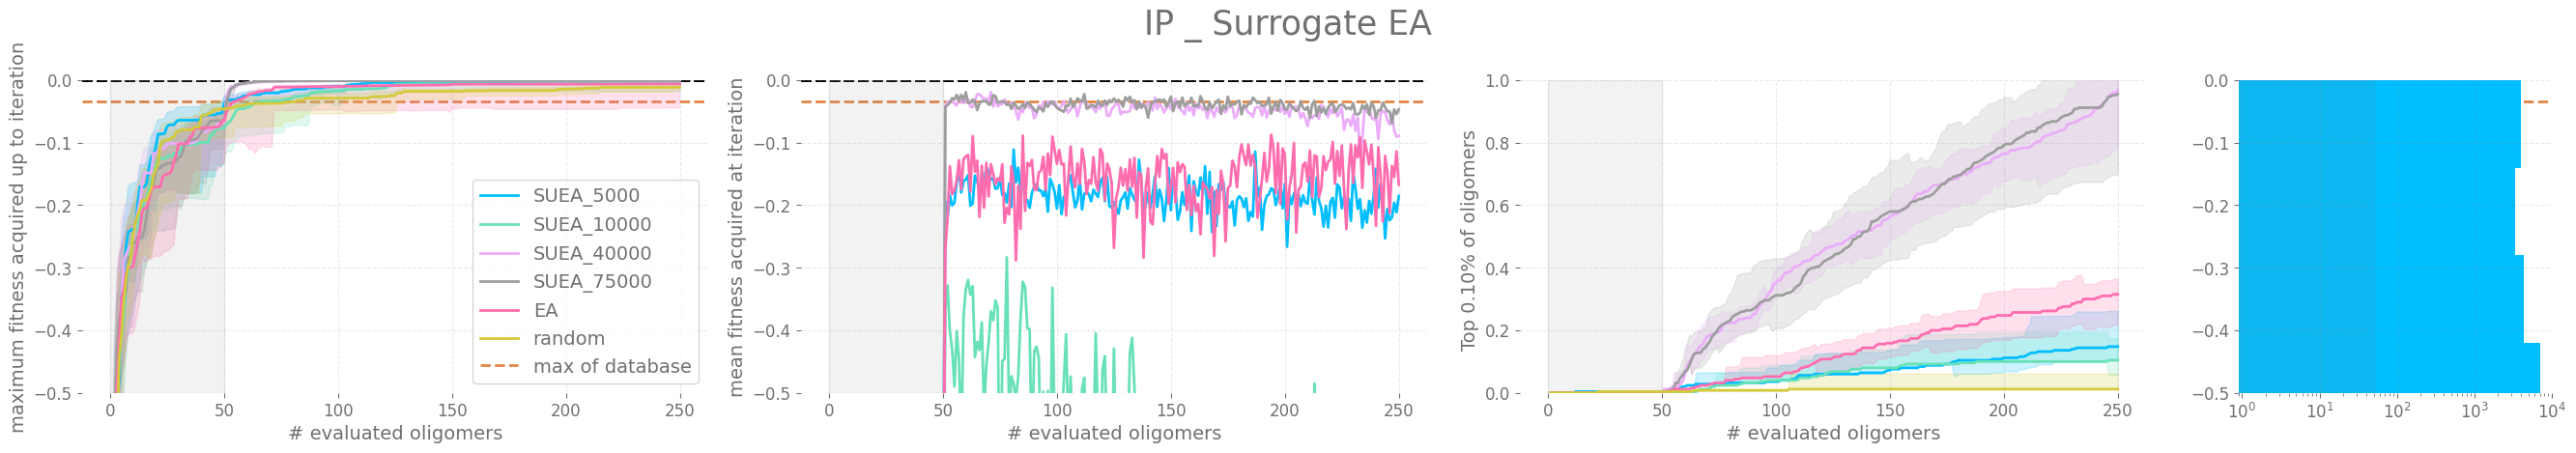

In [53]:
import glob
import pickle
target_name = 'fosc1'
aim = 10.0
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
def plot_SUEA_number(target_name,aim,ylim=[-6,0],topKmol=1000):
    BOresults_list = []
    for num_molecules in [5000,10000,40000,75000]:
        BOresults_list.append(load_search_data(f'ea_surrogate_{target_name}_{num_molecules}','20240106','benchmark'))
    BOresults_random = load_search_data(f'random_{target_name}','20240106','benchmark')
    BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240106','benchmark')
    fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [4, 4, 4 ,2]}, figsize=[3.2 * 8.4, 4.8])#, sharey=True)
    nb_iteration = 250
    operation = np.max
    nb_initialisation = 0
    cool_colors = ['C0', 'C3', 'C4', 'C5', 'C6', 'C7']
    for id, num_molecules in enumerate([5000,10000,40000,75000]):
        plot_exploration_evolution(BOresults_list[id], df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=cool_colors[id], label=f'SUEA_{num_molecules}',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    # for all axis shade area from 0 to 20 
    for ax in axs:
        target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
        min_target_out_of_database = -np.sort(-target)[1000]
        ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
        ax.axvspan(0, 50, alpha=0.1, color='grey')
        ax.set_ylim(ylim)
    axs[2].set_ylim(0,100)
    #plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

    axs[0].legend()
    fig.suptitle(f'{target_name} _ Surrogate EA',fontsize=25)
    fig.tight_layout()
    return fig,axs  
fig,ax = plot_SUEA_number('IP',5.5,ylim=[-0.5,0],topKmol=82)
ax[2].set_ylim(0,1)

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.0, 1.0)

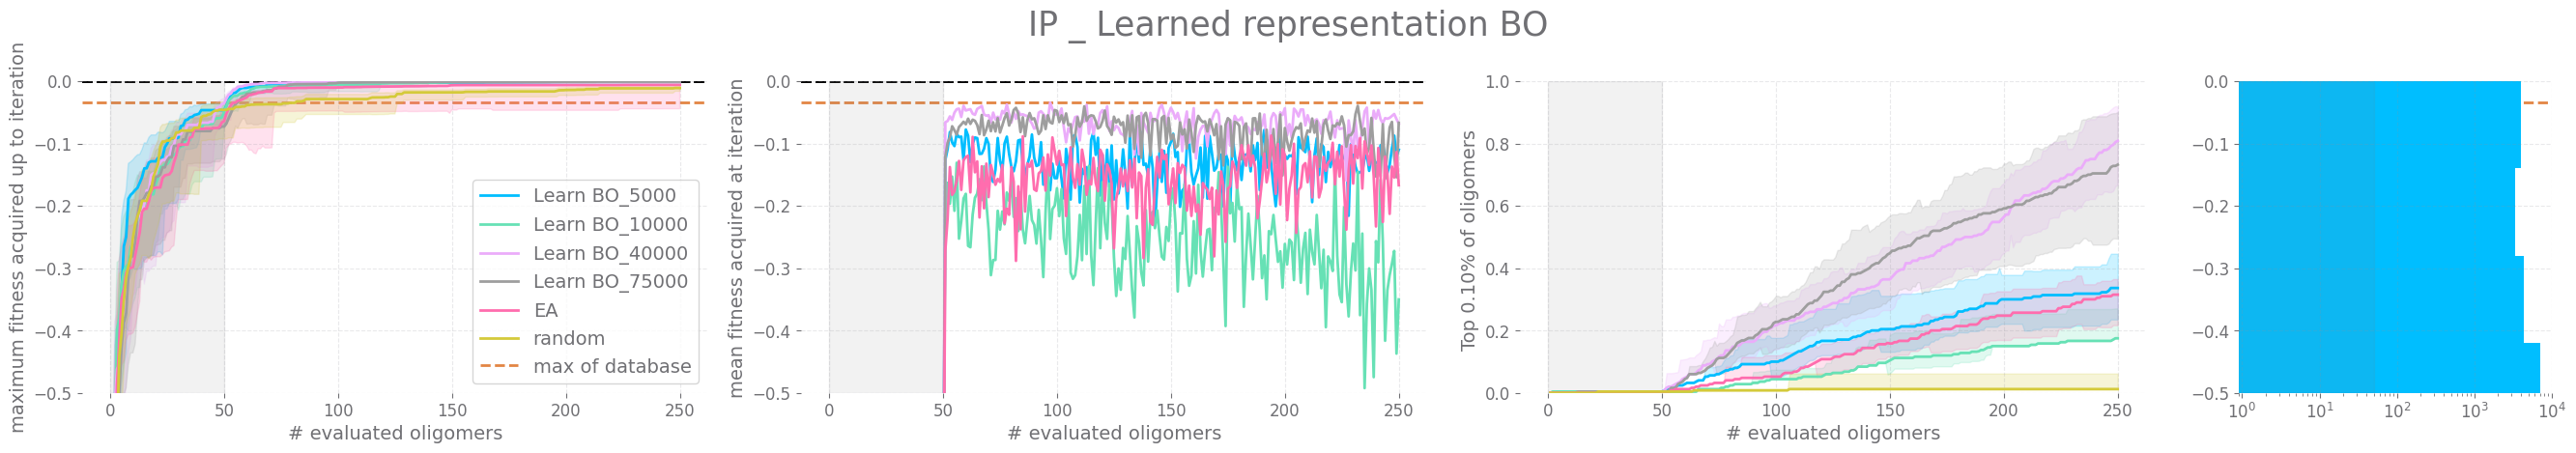

In [51]:
import glob
import pickle
target_name = 'fosc1'
aim = 10.0
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
def plot_num_impact(target_name,aim,ylim=[-6,0],topKmol=1000):
    BOresults_list = []
    for num_molecules in [5000,10000,40000,75000]:
        BOresults_list.append(load_search_data(f'graph_frag_{target_name}_{num_molecules}','20240106','benchmark'))
    BOresults_random = load_search_data(f'random_{target_name}','20240106','benchmark')
    BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240106','benchmark')
    fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [4, 4, 4 ,2]}, figsize=[3.2 * 8.4, 4.8])#, sharey=True)
    nb_iteration = 250
    operation = np.max
    nb_initialisation = 0
    color_list = ['C0','C3','C4','C5','C6','C7']
    for id, num_molecules in enumerate([5000,10000,40000,75000]):
        plot_exploration_evolution(BOresults_list[id], df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=color_list[id], label=f'Learn BO_{num_molecules}',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation,target_name=target_name,aim=aim,topKmol=topKmol)
    # for all axis shade area from 0 to 20 
    for ax in axs:
        target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
        min_target_out_of_database = -np.sort(-target)[1000]
        ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
        ax.axvspan(0, 50, alpha=0.1, color='grey')
        ax.set_ylim(ylim)
    #plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')
    axs[2].set_ylim(0,100)
    axs[0].legend()
    fig.suptitle(f'{target_name} _ Learned representation BO',fontsize=25)
    fig.tight_layout()
    return fig,axs


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid valu

(0.0, 1.0)

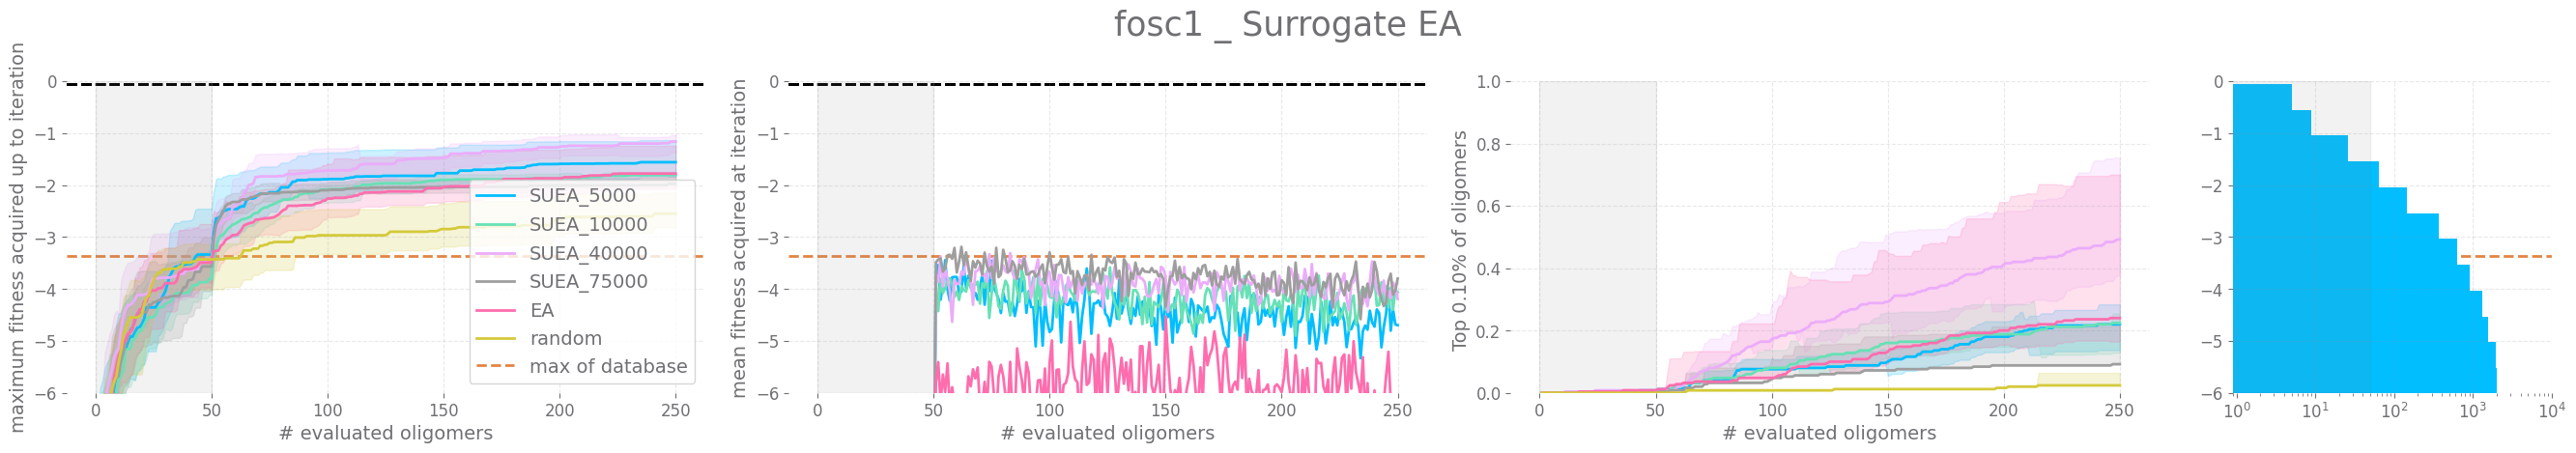

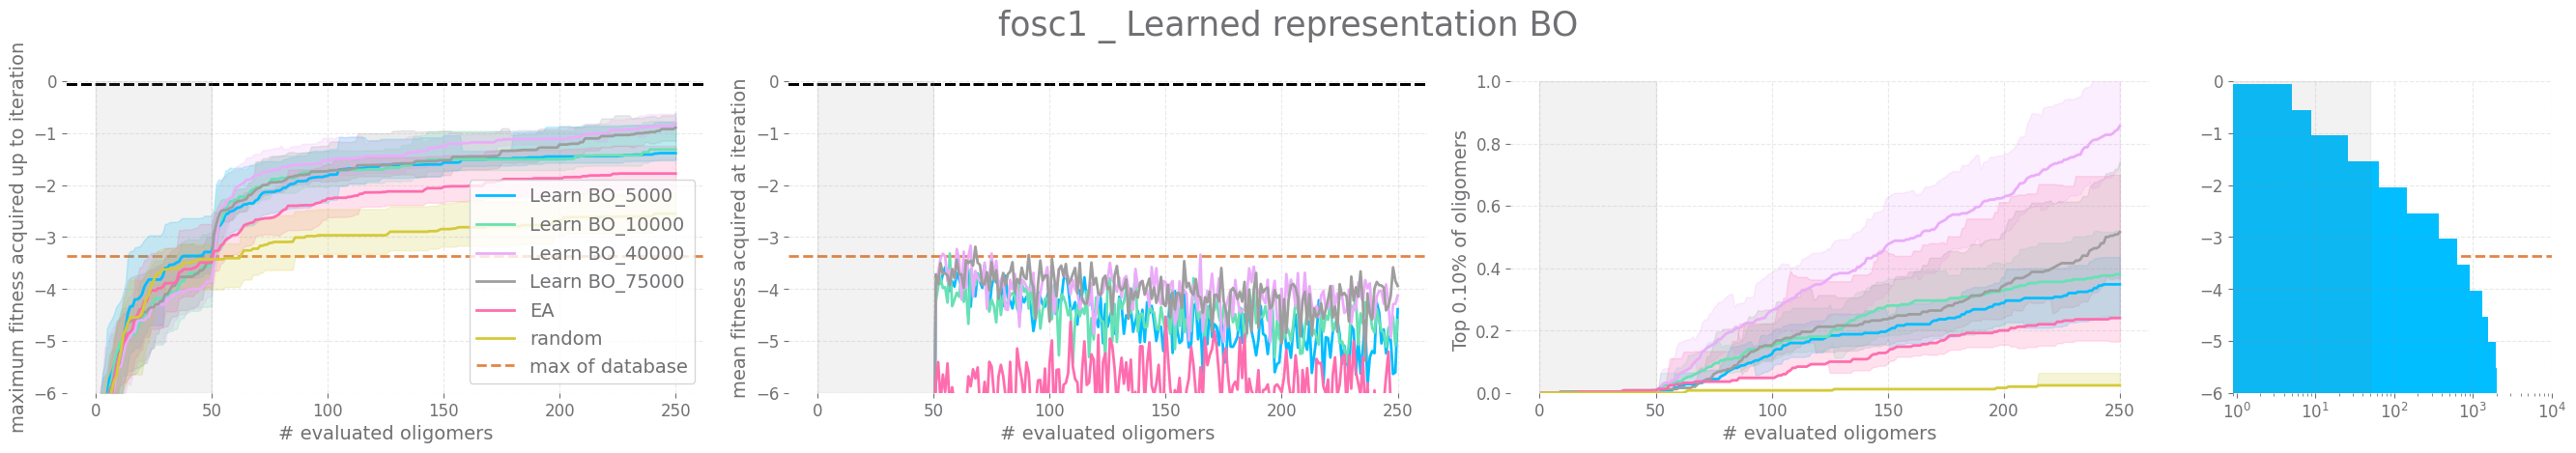

In [55]:
fig,ax = plot_SUEA_number('fosc1',10,ylim=[-6,0],topKmol=82)
ax[2].set_ylim(0,1)
fig,ax =plot_num_impact('fosc1',10,ylim=[-6,0],topKmol=82)
ax[2].set_ylim(0,1)

5000 198
10000 219
40000 250
75000 180


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


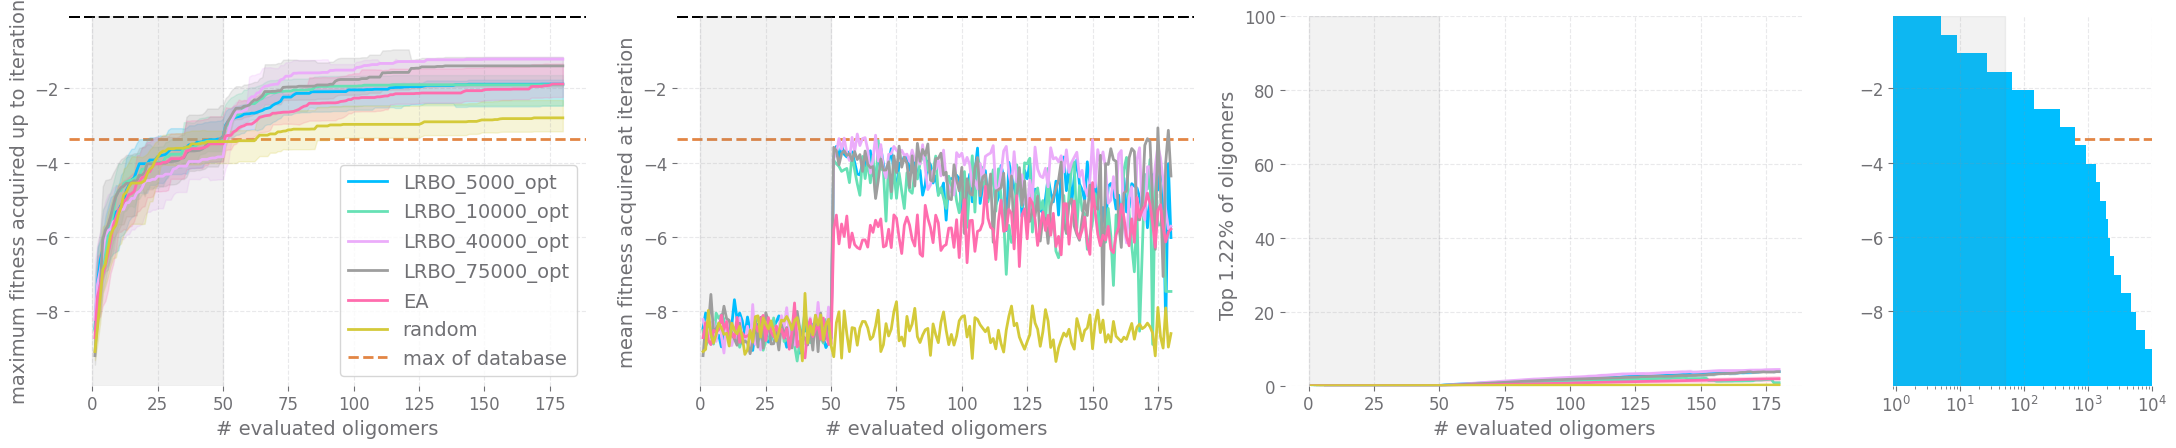

In [43]:
import glob
import pickle
target_name = 'fosc1'
aim = 10.0
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
BOresults_list = []
for num_molecules in [5000,10000,40000,75000]:
    BOresults_list.append(load_search_data(f'graph_frag_{target_name}_{num_molecules}_opt','*','benchmark'))
    print(num_molecules, max([len(x['fitness_acquired']) for x in BOresults_list[-1]]))
BOresults_random = load_search_data(f'random_{target_name}','20240106','benchmark')
BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240106','benchmark')
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [4, 4, 4 ,2]}, figsize=[3.2 * 8.4, 4.8])#, sharey=True)
nb_iteration = 180
operation = np.max
nb_initialisation = 0
color_list = ['C0','C3','C4','C5','C6','C7']
for id, num_molecules in enumerate([5000,10000,40000,75000]):
    plot_exploration_evolution(BOresults_list[id], df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=color_list[id], label=f'LRBO_{num_molecules}_opt',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation,target_name=target_name,aim=aim)
# for all axis shade area from 0 to 20 
for ax in axs:
    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, 50, alpha=0.1, color='grey')
    #ax.set_ylim(-1,0)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')
axs[2].set_ylim(0,100)
axs[0].legend()


5000 250
10000 250
40000 250
75000 250


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


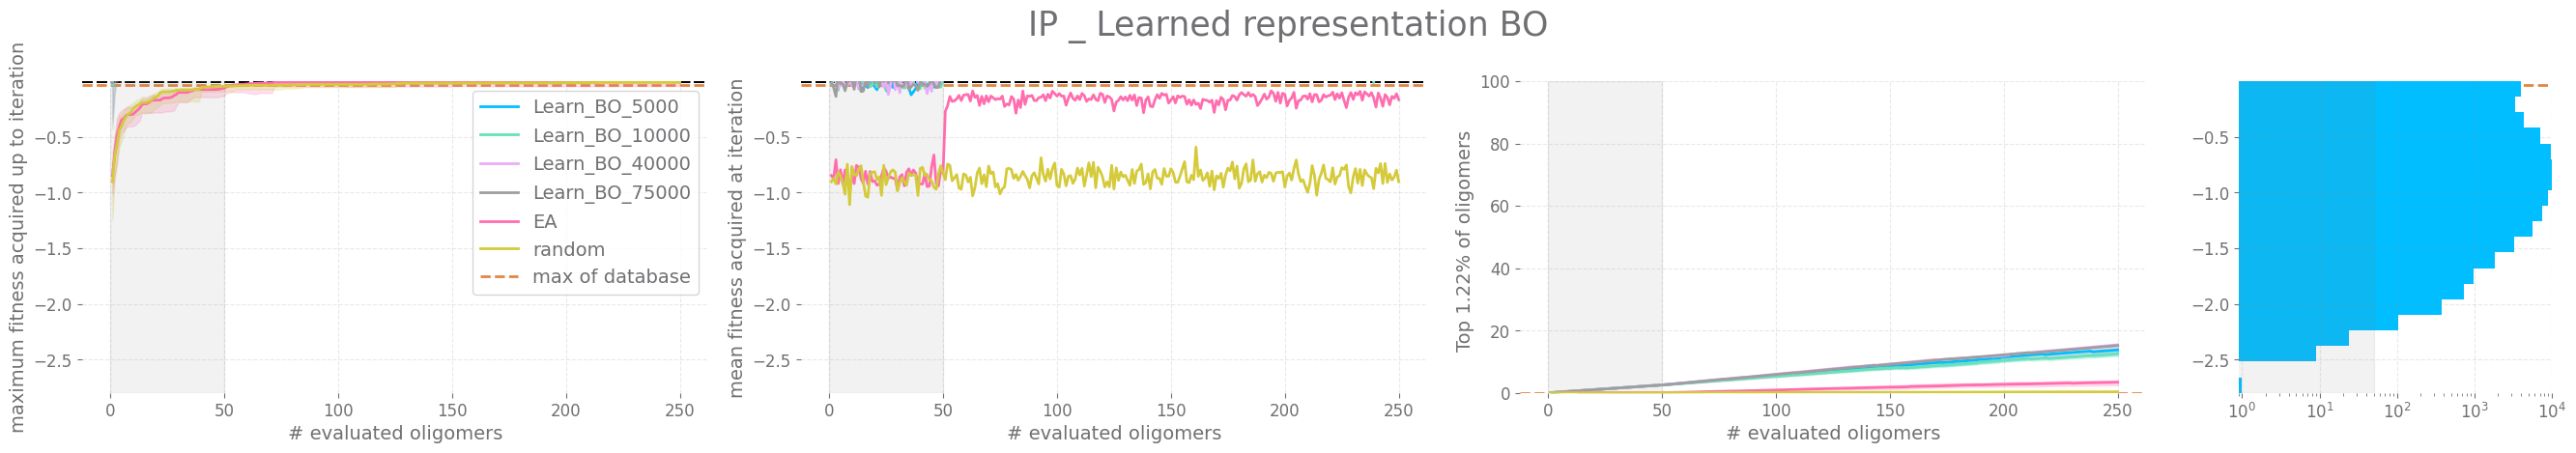

In [44]:
import glob
import pickle
target_name = 'IP'
aim = 5.5
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
BOresults_list = []
for num_molecules in [5000,10000,40000,75000]:
    BOresults_list.append(load_search_data(f'graph_frag_{target_name}_{num_molecules}','*','benchmark'))
    print(num_molecules, max([len(x['fitness_acquired']) for x in BOresults_list[-1]]))
BOresults_random = load_search_data(f'random_{target_name}','20240106','benchmark')
BOresults_EA = load_search_data(f'evolution_algorithm_{target_name}','20240106','benchmark')
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [4, 4, 4 ,2]}, figsize=[3.2 * 8.4, 4.8])#, sharey=True)
nb_iteration = 250
operation = np.max
nb_initialisation = 0
color_list = ['C0','C3','C4','C5','C6','C7']
for id, num_molecules in enumerate([5000,10000,40000,75000]):
    plot_exploration_evolution(BOresults_list[id], df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=color_list[id], label=f'Learn_BO_{num_molecules}',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation,target_name=target_name,aim=aim)
# for all axis shade area from 0 to 20 
for ax in axs:
    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, 50, alpha=0.1, color='grey')
    #ax.set_ylim(-1,0)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')
axs[2].set_ylim(0,100)
axs[0].legend()
fig.suptitle('IP _ Learned representation BO',fontsize=25)
fig.tight_layout()

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


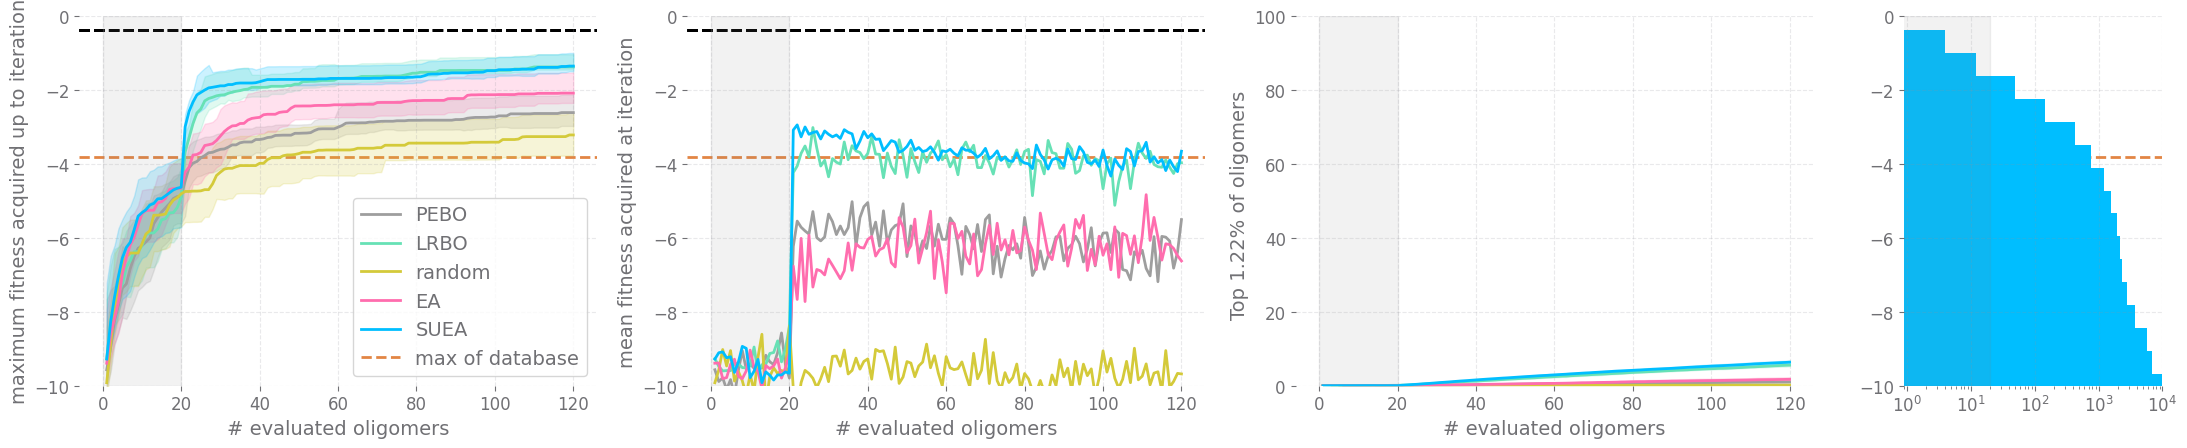

In [45]:
import glob
import pickle
target_name = 'target'
aim = 0.0
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
BOresults_random = load_search_data('random','20231207','benchmark')
BOresults_precursor = load_search_data('precursor','20231208','benchmark')
BOresults_graph_frag = load_search_data('graph_frag','20231207','benchmark')
BOresults_EA = load_search_data('evolution_algorithm','20231207','benchmark')
BOresults_SuEA = load_search_data('ea_surrogate','*','benchmark')
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [4, 4, 4 ,2]}, figsize=[3.2 * 8.4, 4.8])#, sharey=True)
nb_iteration = 120
operation = np.max
nb_initialisation = 30
plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='PEBO',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_graph_frag, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF'], label='LRBO',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation,target_name=target_name,aim=aim)
plot_exploration_evolution(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='SUEA',operation=operation,target_name=target_name,aim=aim)
# for all axis shade area from 0 to 20 
for ax in axs:
    target = df_total[target_name].apply(lambda x: -np.sqrt((x-aim)**2)).values
    min_target_out_of_database = -np.sort(-target)[1000]
    ax.axhline(y=min_target_out_of_database,label='max of database', color='C8', linestyle="--", zorder=0)
    ax.axvspan(0, 20, alpha=0.1, color='grey')
    ax.set_ylim(-10,0)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')
axs[2].set_ylim(0,100)
axs[0].legend()

/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index 3 is out of bounds for axis 0 with size 3

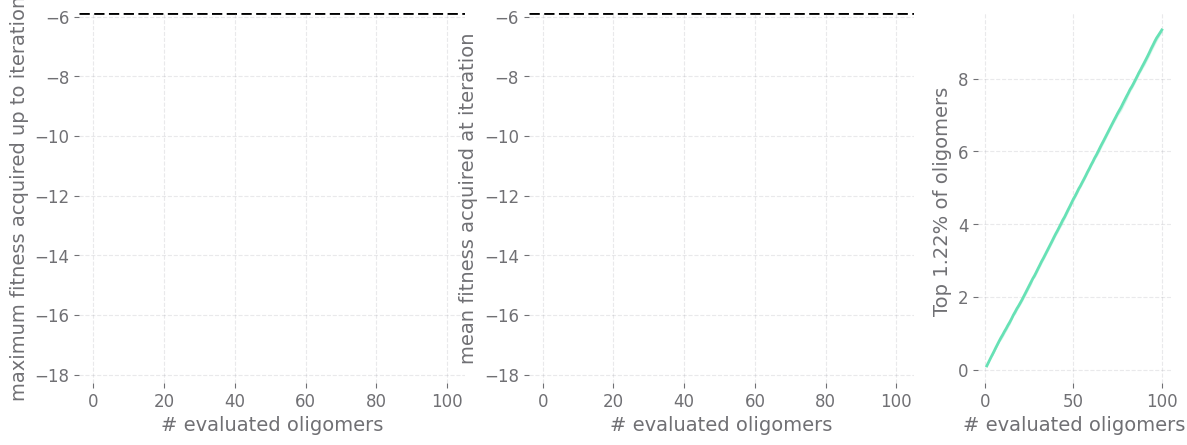

In [46]:
import glob
import pickle
def load_search_data(search_type, date,test_name):
    files = glob.glob(f'data/output/search_experiment/{test_name}/'+search_type+'/'+date+'/*.pkl')
    BOresults = []
    for file in files:
        with open(file, 'rb') as f:
            BOresults.append(pickle.load(f))
    return BOresults
#BOresults_random = load_search_data('random','20231208','exp4_search_space_0')
#BOresults_precursor = load_search_data('precursor','*','exp4_search_space_5')
BOresults_graph_frag = load_search_data('graph_frag','*','exp4_search_space_5')
BOresults_EA = load_search_data('evolution_algorithm','*','exp4_search_space_5')
BOresults_SuEA = load_search_data('ea_surrogate','*','exp4_search_space_5')

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [4, 4,2]}, figsize=[2.2 * 6.4, 4.8])#, sharey=True)
nb_iteration = 100
operation = np.max
nb_initialisation = 50
#plot_exploration_evolution(BOresults_precursor, df_total, nb_initialisation,nb_iteration=nb_iteration,axs=axs,color=search_to_color['BO'],label='BO (precursor)',operation=operation)
plot_exploration_evolution(BOresults_graph_frag, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF'], label='BO (new)',operation=operation)
#plot_exploration_evolution(BOresults_random, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['random'],label='random',operation=operation)
plot_exploration_evolution(BOresults_EA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['evolutionary'],label='EA',operation=operation)
plot_exploration_evolution(BOresults_SuEA, df_total,nb_initialisation, nb_iteration=nb_iteration,axs=axs,color=search_to_color['RF (div)'],label='surrogate EA',operation=operation)
#plot_exploration_evolution(BOresults_slatm_org, df_total, nb_iteration=200,axs=axs,color=search_to_color['RF (div)'],label='BO (SLATM org)')

axs[0].legend()

In [ ]:
def plot_hist_new(Bo_results,axis,label,color):
    new_fitness_acquired = []
    new_inchikey = []
    for x in Bo_results:
        for id,i in enumerate(x['InchiKey_acquired']):
            if i not in df_total['InChIKey'].tolist() and i not in new_inchikey:
                new_fitness_acquired.append(x['fitness_acquired'][id])
                new_inchikey.append(i)
                #print(x['fitness_acquired'][id])

    axis.hist(new_fitness_acquired,bins=20,label=label,color=color,alpha=0.5,density=True)
    axis.set_xlabel('Fitness')
    axis.set_ylabel('Frequency')
    axis.set_title('Fitness of new oligomers')

    
#BOresults_precursor = load_search_data('precursor','20231208','exp4_search_space_0')
fig,axis = plt.subplots(2,2,figsize=(15,15))
axis = axis.flatten()
for id,search_space in enumerate([0,3,5,8]):
    BOresults_graph_frag = load_search_data('graph_frag','*',f'exp4_search_space_{search_space}')
    BOresults_EA = load_search_data('evolution_algorithm','*',f'exp4_search_space_{search_space}')
    BOresults_SuEA = load_search_data('ea_surrogate','*',f'exp4_search_space_{search_space}')
    plot_hist_new(BOresults_graph_frag,axis[id],color=search_to_color['RF'], label='BO (new)')
    plot_hist_new(BOresults_EA,axis[id],color=search_to_color['evolutionary'], label='EA')
    plot_hist_new(BOresults_SuEA,axis[id],color=search_to_color['BO'], label='EA _surrogate')
    axis[id].set_title('unique new oligomers {}'.format(search_space))
    axis[id].legend()
plt.show()
            #break

In [ ]:
def plot_hist_new(Bo_results,axis,label,color):
    new_fitness_acquired = []
    new_inchikey = []
    for x in Bo_results:
        for id,i in enumerate(x['InchiKey_acquired']):
            if id>50:
                new_fitness_acquired.append(x['fitness_acquired'][id])
                #new_inchikey.append(i)
                #print(x['fitness_acquired'][id])
    axis.hist(new_fitness_acquired,bins=20,label=label,color=color,alpha=0.5,density=True)
    axis.set_xlabel('Fitness')
    axis.set_ylabel('Frequency')
    axis.set_title('Fitness of new oligomers')

    
#BOresults_precursor = load_search_data('precursor','20231208','exp4_search_space_0')
fig,axis = plt.subplots(2,2,figsize=(15,15))
axis = axis.flatten()
for id,search_space in enumerate([0,3,5,8]):
    BOresults_graph_frag = load_search_data('graph_frag','*',f'exp4_search_space_{search_space}')
    BOresults_EA = load_search_data('evolution_algorithm','*',f'exp4_search_space_{search_space}')
    BOresults_SuEA = load_search_data('ea_surrogate','*',f'exp4_search_space_{search_space}')
    plot_hist_new(BOresults_graph_frag,axis[id],color=search_to_color['RF'], label='BO (new)')
    plot_hist_new(BOresults_EA,axis[id],color=search_to_color['evolutionary'], label='EA')
    plot_hist_new(BOresults_SuEA,axis[id],color=search_to_color['BO'], label='EA _surrogate')
    axis[id].set_title('oligomers suggested {}'.format(search_space))
    axis[id].legend()
plt.show()
            #break

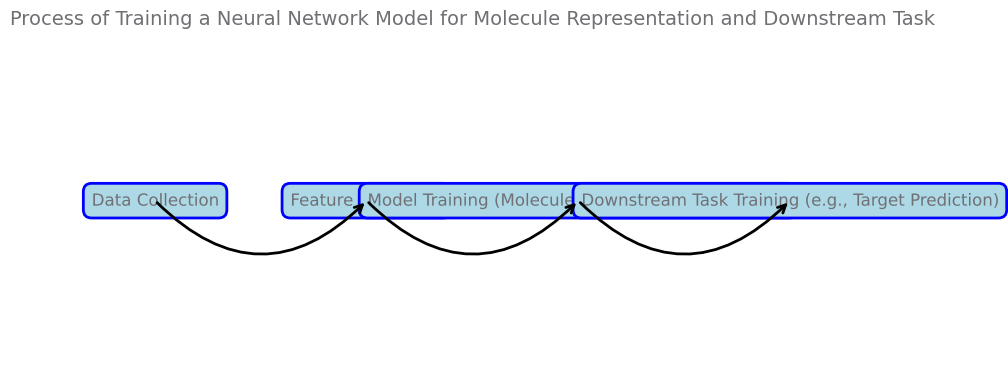

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.patheffects import Normal

# Define the steps in the process
steps = [
    'Data Collection',
    'Feature Extraction',
    'Model Training (Molecule Representation Learning)',
    'Downstream Task Training (e.g., Target Prediction)'
]

# Define the connections between the steps
connections = [
    (0, 1),  # Data Collection -> Feature Extraction
    (1, 2),  # Feature Extraction -> Model Training
    (2, 3)   # Model Training -> Downstream Task Training
]

# Plot the diagram
fig, ax = plt.subplots(figsize=(10, 4))
for i, step in enumerate(steps):
    bbox_props = dict(boxstyle="round,pad=0.5", fc="lightblue", ec="blue", lw=2)
    ax.text(i, 0, step, ha='center', va='center', fontsize=12, bbox=bbox_props, path_effects=[Normal()])
for connection in connections:
    ax.annotate('', xy=(connection[1], 0), xytext=(connection[0], 0),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5', lw=2),
                path_effects=[Normal()])
ax.set_xlim(-0.5, len(steps) - 0.5)
ax.set_ylim(-1, 1)
ax.axis('off')
ax.set_title('Process of Training a Neural Network Model for Molecule Representation and Downstream Task', fontsize=14)
plt.tight_layout()
plt.show()
